In [2]:
# RoPE Transformer for Oxford-IIIT Pet Dataset
# ============================================

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet18_Weights

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Loading and Preprocessing
# ==============================

def load_dataset(dataset_name='pets', batch_size=32, img_size=224):
    """
    Load the specified dataset and prepare data loaders
    
    Parameters:
    dataset_name (str): One of 'pets', 'cifar10', or 'cifar100'
    batch_size (int): Size of mini-batches
    img_size (int): Images will be resized to this size
    
    Returns:
    train_loader, val_loader, class_names
    """
    # Data augmentation and normalization for training
    # Just normalization for validation
    
    # Define transformations based on the dataset
    if dataset_name.lower() in ['cifar10', 'cifar100']:
        # CIFAR datasets use different normalization values
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
            ]),
            'val': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])
            ]),
        }
    else:  # pets dataset
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
    
    # Load the appropriate dataset
    if dataset_name.lower() == 'cifar10':
        print("Loading CIFAR-10 dataset...")
        train_dataset = datasets.CIFAR10(
            root='./data',
            train=True,
            download=True,
            transform=data_transforms['train']
        )
        
        val_dataset = datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=data_transforms['val']
        )
        
        class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                      'dog', 'frog', 'horse', 'ship', 'truck']
        
    elif dataset_name.lower() == 'cifar100':
        print("Loading CIFAR-100 dataset...")
        train_dataset = datasets.CIFAR100(
            root='./data',
            train=True,
            download=True,
            transform=data_transforms['train']
        )
        
        val_dataset = datasets.CIFAR100(
            root='./data',
            train=False,
            download=True,
            transform=data_transforms['val']
        )
        
        # Get class names from CIFAR100
        class_names = train_dataset.classes
        
    else:  # Load Oxford-IIIT Pet dataset
        print("Loading Oxford-IIIT Pet dataset...")
        full_dataset = datasets.OxfordIIITPet(
            root='./data',
            split='trainval',
            download=True,
            transform=data_transforms['train']
        )
        
        # Split the dataset into training and validation sets
        train_size = int(0.8 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
        
        # Update the transform for validation dataset
        val_dataset.dataset.transform = data_transforms['val']
        
        # Get class names
        class_names = full_dataset.classes
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                             shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=4)
    
    print(f"Number of classes: {len(class_names)}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    return train_loader, val_loader, class_names

def load_pet_dataset(batch_size=32, img_size=224):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    # Load the Oxford-IIIT Pet dataset
    full_dataset = datasets.OxfordIIITPet(
        root='./data',
        split='trainval',
        download=True,
        transform=data_transforms['train']
    )
    
    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Update the transform for validation dataset
    val_dataset.dataset.transform = data_transforms['val']
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Get class names
    class_names = full_dataset.classes
    
    return train_loader, val_loader, class_names

# Rotary Position Embeddings
# ==========================

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        
        # Generate frequency bands
        freqs = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        
        # Create position sequence
        t = torch.arange(max_seq_len, dtype=torch.float)
        freqs = torch.outer(t, freqs)  # [seq_len, dim/2]
        
        # Create sin and cos for rotation
        self.register_buffer("freqs_cos", freqs.cos())  # [seq_len, dim/2]
        self.register_buffer("freqs_sin", freqs.sin())  # [seq_len, dim/2]
        
    def forward(self, x, seq_dim=1):
        # x: [batch, seq_len, dim]
        seq_len = x.shape[seq_dim]
        
        # Get the appropriate vectors for this sequence length
        freqs_cos = self.freqs_cos[:seq_len]  # [seq_len, dim/2]
        freqs_sin = self.freqs_sin[:seq_len]  # [seq_len, dim/2]
        
        return freqs_cos, freqs_sin

def apply_rotary_pos_emb(q, k, cos, sin):
    # q, k: [batch, seq_len, heads, dim]
    # cos, sin: [seq_len, dim/2]
    
    # Reshape for broadcasting
    cos = cos.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim/2]
    sin = sin.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim/2]
    
    # Split dimensions for rotation
    q1, q2 = q[..., 0::2], q[..., 1::2]  # Each with half the dimension
    k1, k2 = k[..., 0::2], k[..., 1::2]
    
    # Apply rotation using the rotation matrix
    q_out = torch.cat([-q2 * sin + q1 * cos, q1 * sin + q2 * cos], dim=-1)
    k_out = torch.cat([-k2 * sin + k1 * cos, k1 * sin + k2 * cos], dim=-1)
    
    return q_out, k_out

# Multi-head Self-Attention with RoPE
# ===================================

class RoPEMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"
        
        # Linear projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Rotary positional embedding
        self.rope = RotaryPositionalEmbedding(self.head_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project and reshape for multi-head attention
        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Get rotary embeddings
        cos, sin = self.rope(x)
        
        # Apply rotary embeddings
        q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Reshape for matrix multiplication
        q = q.transpose(1, 2)  # [batch, heads, seq_len, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax and compute attention output
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        
        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.out_proj(attn_output)
        
        return output


Using device: cuda


In [3]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = RoPEMultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attn(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

class RoPETransformerEncoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, num_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


In [4]:
# RoPE Vision Transformer for Oxford-IIIT Pet Dataset
# ==================================================

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Loading and Preprocessing
# ==============================

def load_pet_dataset(batch_size=32, img_size=224):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    
    # Load the Oxford-IIIT Pet dataset
    full_dataset = datasets.OxfordIIITPet(
        root='./data',
        split='trainval',
        download=True,
        transform=data_transforms['train']
    )
    
    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    # Update the transform for validation dataset
    val_dataset.dataset.transform = data_transforms['val']
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    
    # Get class names
    class_names = full_dataset.classes
    
    return train_loader, val_loader, class_names

# Rotary Position Embeddings
# ==========================

class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len=2048):
        super().__init__()
        self.dim = dim
        self.max_seq_len = max_seq_len
        
        # Generate frequency bands
        freqs = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        
        # Create position sequence
        t = torch.arange(max_seq_len, dtype=torch.float)
        freqs = torch.outer(t, freqs)  # [seq_len, dim/2]
        
        # Create sin and cos for rotation
        self.register_buffer("freqs_cos", freqs.cos())  # [seq_len, dim/2]
        self.register_buffer("freqs_sin", freqs.sin())  # [seq_len, dim/2]
        
    def forward(self, x, seq_dim=1):
        # x: [batch, seq_len, dim]
        seq_len = x.shape[seq_dim]
        
        # Get the appropriate vectors for this sequence length
        freqs_cos = self.freqs_cos[:seq_len]  # [seq_len, dim/2]
        freqs_sin = self.freqs_sin[:seq_len]  # [seq_len, dim/2]
        
        return freqs_cos, freqs_sin

def apply_rotary_pos_emb(q, k, cos, sin):
    # q, k: [batch, seq_len, heads, dim]
    # cos, sin: [seq_len, dim/2]
    
    # Reshape for broadcasting
    cos = cos.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim/2]
    sin = sin.unsqueeze(0).unsqueeze(2)  # [1, seq_len, 1, dim/2]
    
    # Split dimensions for rotation
    q1, q2 = q[..., 0::2], q[..., 1::2]  # Each with half the dimension
    k1, k2 = k[..., 0::2], k[..., 1::2]
    
    # Apply rotation using the rotation matrix
    q_out = torch.cat([-q2 * sin + q1 * cos, q1 * sin + q2 * cos], dim=-1)
    k_out = torch.cat([-k2 * sin + k1 * cos, k1 * sin + k2 * cos], dim=-1)
    
    return q_out, k_out

# Multi-head Self-Attention with RoPE
# ===================================

class RoPEMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"
        
        # Linear projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Rotary positional embedding
        self.rope = RotaryPositionalEmbedding(self.head_dim)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project and reshape for multi-head attention
        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Get rotary embeddings
        cos, sin = self.rope(x)
        
        # Apply rotary embeddings
        q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Reshape for matrix multiplication
        q = q.transpose(1, 2)  # [batch, heads, seq_len, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax and compute attention output
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        
        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.out_proj(attn_output)
        
        return output

# Transformer Encoder Layer with RoPE
# ==================================

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = RoPEMultiHeadAttention(d_model, num_heads)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attn(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

# Vision Transformer (ViT) with RoPE
# =================================

class RoPEViT(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 in_channels=3,
                 num_classes=37,
                 dim=768, 
                 depth=12, 
                 heads=12, 
                 mlp_dim=3072, 
                 dropout=0.1):
        super().__init__()
        
        # Image and patch dimensions
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Patch embedding
        self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model=dim, num_heads=heads, d_ff=mlp_dim, dropout=dropout)
            for _ in range(depth)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(dim)
        
        # Classification head
        self.head = nn.Linear(dim, num_classes)
        
    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # [batch, dim, grid, grid]
        x = x.flatten(2).transpose(1, 2)  # [batch, num_patches, dim]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, num_patches + 1, dim]
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply transformer layers
        for layer in self.layers:
            x = layer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0]
        
        # MLP head
        x = self.head(x)
        
        return x

Using device: cuda


In [5]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc="Training")
    
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward + optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        # Update progress bar
        pbar.set_postfix({"Loss": loss.item(), "Accuracy": torch.sum(preds == labels.data).item() / inputs.size(0)})
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    
    return epoch_loss, epoch_acc.item()

def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    
    return epoch_loss, epoch_acc.item()

# Training Loop
# =============

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        
        # Evaluate
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Learning rate scheduler
        scheduler.step(val_loss)
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
            print(f'New best model saved with accuracy: {val_acc:.4f}')
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print()
    
    # Load best model
    model.load_state_dict(torch.load('best_vit_model.pth'))
    
    return model, history

# Visualization Functions
# ======================

def visualize_predictions(model, val_loader, class_names, num_images=16, device=device):
    model.eval()
    
    # Get a batch of images
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Make predictions
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        _, preds = torch.max(outputs, 1)
    
    # Plot images with predictions
    fig = plt.figure(figsize=(16, 16))
    rows = int(np.ceil(num_images / 4))
    
    for i in range(min(num_images, len(images))):
        ax = fig.add_subplot(rows, 4, i + 1)
        
        # Unnormalize the image - check if it's CIFAR or Pets dataset
        img = images[i].permute(1, 2, 0).numpy()
        
        # Detect which dataset by image size
        if img.shape[0] <= 32:  # CIFAR datasets
            mean = np.array([0.4914, 0.4822, 0.4465])
            std = np.array([0.2470, 0.2435, 0.2616])
        else:  # Pets dataset
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Label with prediction and ground truth
        pred_label = class_names[preds[i]]
        true_label = class_names[labels[i]]
        title_color = 'green' if preds[i] == labels[i] else 'red'
        
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color, fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_training_history(history):
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def display_images(original, adversarial):
    """Display last batch of original and adversarial images."""
    original = original.clamp(0, 1)
    adversarial = adversarial.clamp(0, 1)

    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()

        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()

In [6]:
def main():
    # Get user input for the dataset
    dataset_options = ['pets', 'cifar10', 'cifar100']
    dataset_name = input(f"Choose a dataset {dataset_options}: ").lower().strip()
    
    while dataset_name not in dataset_options:
        print(f"Invalid selection. Please choose from {dataset_options}")
        dataset_name = input(f"Choose a dataset {dataset_options}: ").lower().strip()
    
    # Set appropriate image and batch sizes based on dataset
    if dataset_name in ['cifar10', 'cifar100']:
        default_img_size = 32  # CIFAR's native size
        batch_size = 64        # We can use larger batches for smaller images
    else:
        default_img_size = 224  # Original size used for Pets dataset
        batch_size = 32
    
    # Ask for image size
    try:
        img_size = int(input(f"Enter image size (default: {default_img_size}): ") or default_img_size)
    except ValueError:
        img_size = default_img_size
        print(f"Using default image size: {img_size}")
    
    # Load the dataset
    patch_size = 16 if img_size >= 224 else 4  # Adjust patch size for smaller images
    train_loader, val_loader, class_names = load_dataset(
        dataset_name=dataset_name, 
        batch_size=batch_size, 
        img_size=img_size
    )
    
    num_classes = len(class_names)
    
    print(f"Using image size: {img_size}x{img_size}, patch size: {patch_size}")
    
    # Initialize the ViT model with RoPE
    model = RoPEViT(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=3,
        num_classes=num_classes,
        dim=512,  # Embedding dimension
        depth=8,  # Number of transformer layers
        heads=8,  # Number of attention heads
        mlp_dim=1024,  # Hidden dimension of the MLP
        dropout=0.1
    )
    model = model.to(device)
    
    # Print model summary
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Ask for number of epochs
    try:
        num_epochs = int(input("Enter number of epochs (default: 20): ") or 20)
    except ValueError:
        num_epochs = 20
        print(f"Using default number of epochs: {num_epochs}")
    
    # Train the model
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Visualize predictions
    visualize_predictions(model, val_loader, class_names, num_images=16, device=device)
    
    print("Training complete!")
    return model

Choose a dataset ['pets', 'cifar10', 'cifar100']:  cifar10
Enter image size (default: 32):  


Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of classes: 10
Training samples: 50000
Validation samples: 10000
Using image size: 32x32, patch size: 4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Model Parameters: 16,854,026


Enter number of epochs (default: 20):  10


Epoch 1/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.5460 Acc: 0.4380


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 1.2845 Acc: 0.5346
New best model saved with accuracy: 0.5346

Epoch 2/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.1729 Acc: 0.5804


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 1.0700 Acc: 0.6132
New best model saved with accuracy: 0.6132

Epoch 3/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.0389 Acc: 0.6294


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.9907 Acc: 0.6513
New best model saved with accuracy: 0.6513

Epoch 4/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.9425 Acc: 0.6666


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.9287 Acc: 0.6794
New best model saved with accuracy: 0.6794

Epoch 5/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8689 Acc: 0.6912


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.8880 Acc: 0.6916
New best model saved with accuracy: 0.6916

Epoch 6/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8101 Acc: 0.7142


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.9031 Acc: 0.6866

Epoch 7/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7594 Acc: 0.7305


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7995 Acc: 0.7230
New best model saved with accuracy: 0.7230

Epoch 8/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7122 Acc: 0.7488


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7752 Acc: 0.7342
New best model saved with accuracy: 0.7342

Epoch 9/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6686 Acc: 0.7624


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7476 Acc: 0.7454
New best model saved with accuracy: 0.7454

Epoch 10/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6269 Acc: 0.7794


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7400 Acc: 0.7479
New best model saved with accuracy: 0.7479



<ipython-input-12-8911ceb2fbec>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


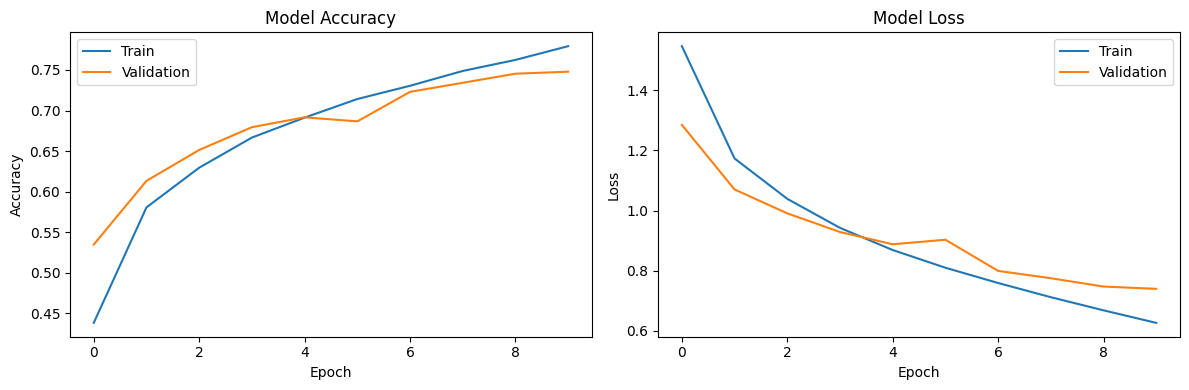

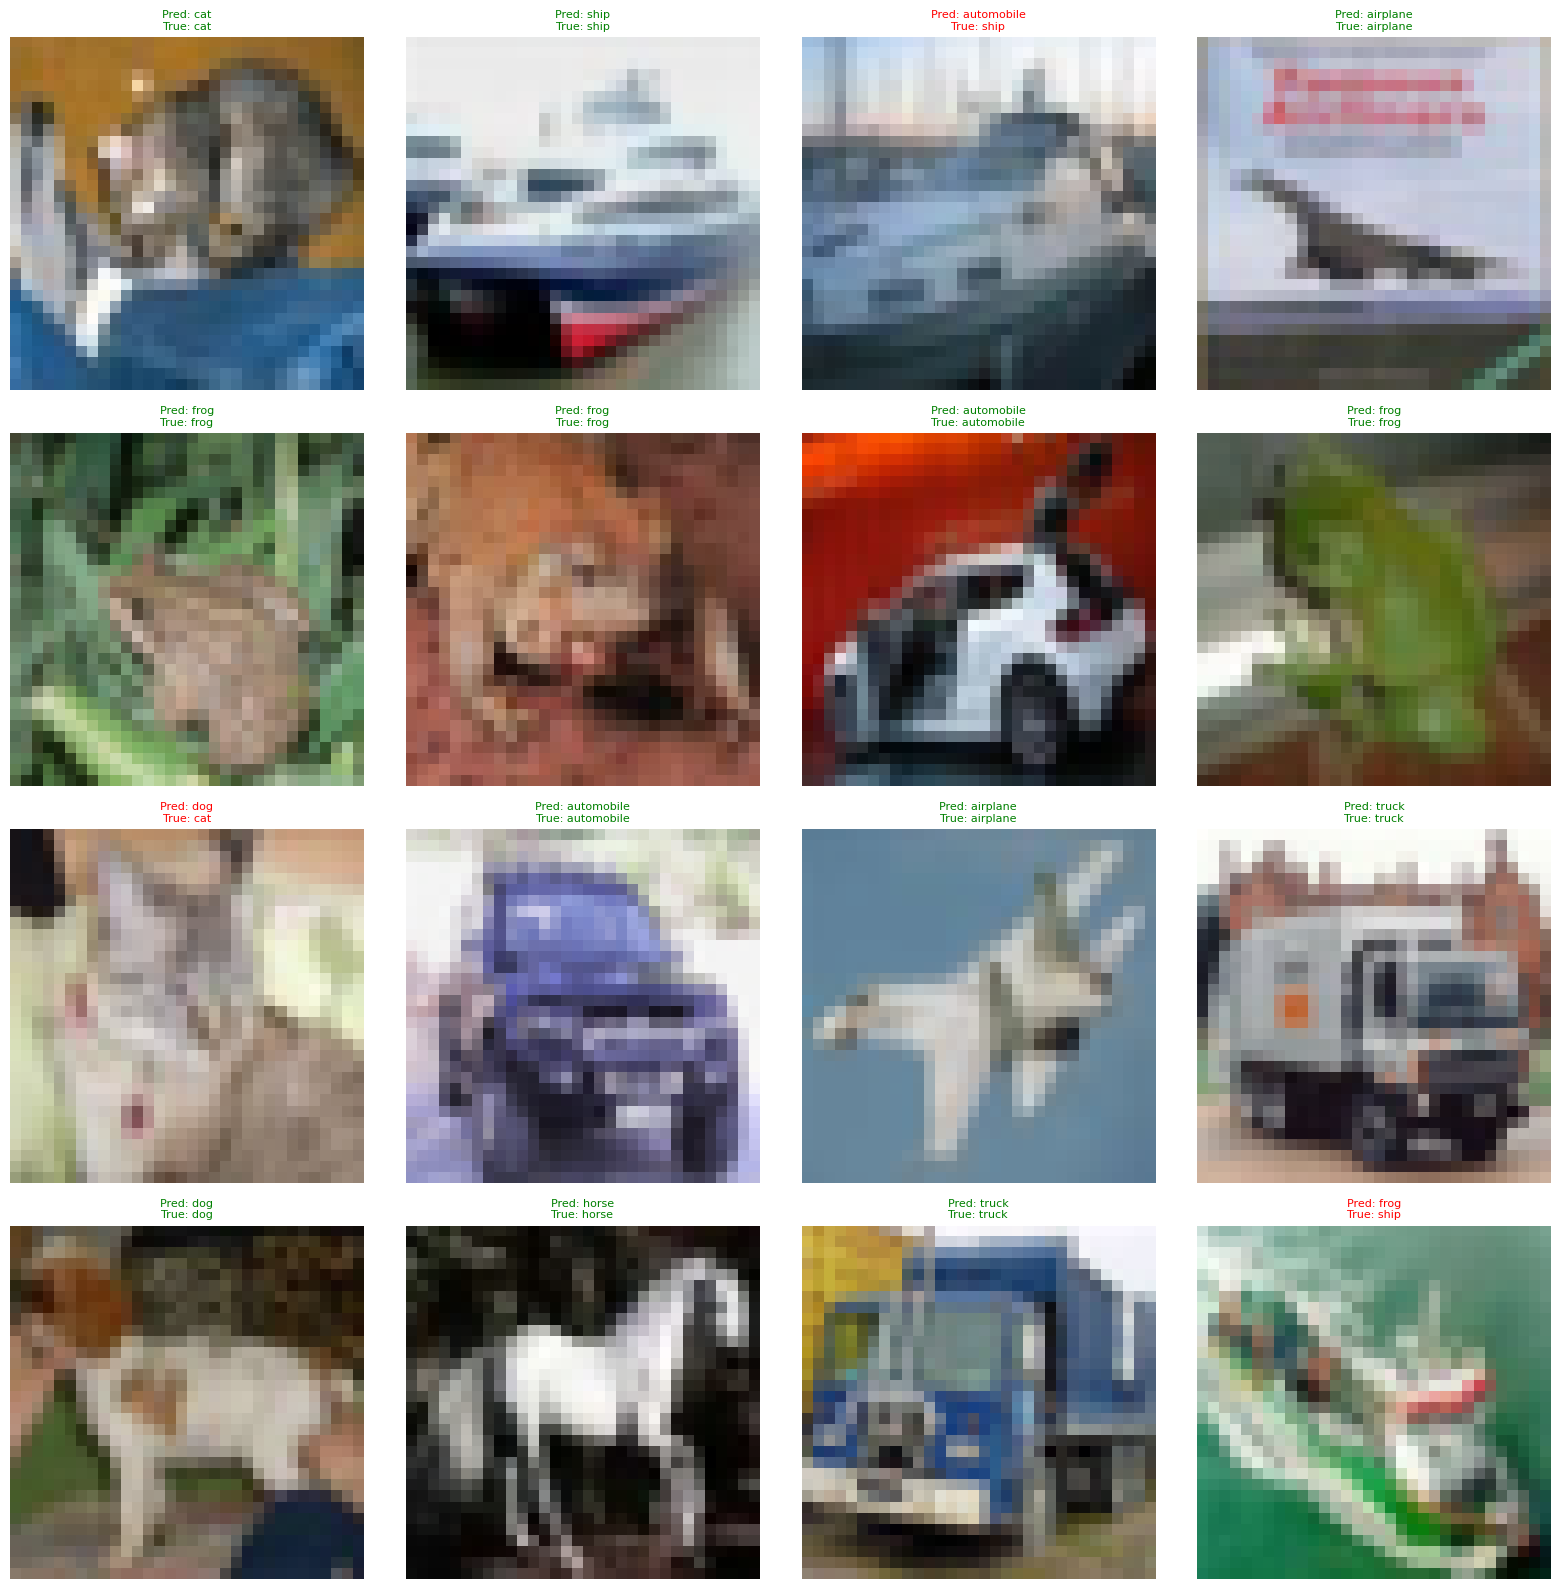

Training complete!


In [14]:
model = main()

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.fft as fft

class FrequencyPixelAttacks(nn.Module):
    """
    A PyTorch transform to apply various frequency-based and pixel-based attacks.
    """
    def __init__(self, attack_type='phase', epsilon=0.1, frequency_radius=0.1, num_pixels=100, noise_std=0.05, seed=None):
        super(FrequencyPixelAttacks, self).__init__()
        self.attack_type = attack_type
        self.epsilon = epsilon
        self.frequency_radius = frequency_radius
        self.num_pixels = num_pixels
        self.noise_std = noise_std
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
    
    def forward(self, img):
        perturbed_img = img.clone().detach()
        if self.attack_type == 'phase':
            perturbed_img = self._phase_attack(perturbed_img)
        elif self.attack_type == 'magnitude':
            perturbed_img = self._magnitude_attack(perturbed_img)
        elif self.attack_type == 'low_freq':
            perturbed_img = self._low_frequency_attack(perturbed_img)
        elif self.attack_type == 'high_freq':
            perturbed_img = self._high_frequency_attack(perturbed_img)
        elif self.attack_type == 'pixel':
            perturbed_img = self._pixel_attack(perturbed_img)
        elif self.attack_type == 'normal':
            perturbed_img = self._normal_noise_attack(perturbed_img)
        else:
            raise ValueError(f"Unknown attack type: {self.attack_type}")
        return torch.clamp(perturbed_img, 0, 1)
    
    def _phase_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            phase_noise = torch.randn_like(phase) * self.epsilon
            perturbed_phase = phase + phase_noise
            f_transform_perturbed = magnitude * torch.exp(1j * perturbed_phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _magnitude_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            magnitude = torch.abs(f_transform)
            phase = torch.angle(f_transform)
            magnitude_noise = torch.randn_like(magnitude) * self.epsilon * magnitude
            perturbed_magnitude = magnitude + magnitude_noise
            f_transform_perturbed = perturbed_magnitude * torch.exp(1j * phase)
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _create_frequency_mask(self, height, width, is_low_freq=True):
        y_indices, x_indices = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
        y_indices = y_indices - height // 2
        x_indices = x_indices - width // 2
        distance = torch.sqrt(y_indices**2 + x_indices**2).float()
        max_distance = torch.sqrt(torch.tensor(height**2 + width**2, dtype=torch.float32))
        distance /= max_distance
        return (distance <= self.frequency_radius).float() if is_low_freq else (distance >= (1 - self.frequency_radius)).float()
    
    def _low_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=True).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _high_frequency_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = torch.zeros_like(img)
        mask = self._create_frequency_mask(height, width, is_low_freq=False).to(img.device)
        for c in range(channels):
            f_transform = fft.fftshift(fft.fft2(img[:, c]))
            noise = (torch.randn_like(f_transform.real) + 1j * torch.randn_like(f_transform.imag)) * self.epsilon
            f_transform_perturbed = f_transform + noise * mask
            img_perturbed = fft.ifft2(fft.ifftshift(f_transform_perturbed)).real
            perturbed_img[:, c] = img_perturbed
        return perturbed_img
    
    def _pixel_attack(self, img):
        batch, channels, height, width = img.shape
        perturbed_img = img.clone()
        num_pixels = min(self.num_pixels, height * width)
        pixel_indices = torch.randint(0, height * width, (batch, num_pixels))
        y_indices, x_indices = pixel_indices // width, pixel_indices % width
        for b in range(batch):
            for c in range(channels):
                for i in range(num_pixels):
                    perturbed_img[b, c, y_indices[b, i], x_indices[b, i]] += torch.randn(1).item() * self.epsilon
        return perturbed_img
    
    def _normal_noise_attack(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise

def display_image(original, adversarial):
    """Display last batch of original and adversarial images."""
    fig, axes = plt.subplots(2, len(original), figsize=(16, 10))
    
    for i in range(len(original)):
        orig_img = original[i].permute(1, 2, 0).cpu().numpy()
        adv_img = adversarial[i].permute(1, 2, 0).cpu().numpy()
        
        orig_img = np.clip(orig_img, 0, 1)
        adv_img = np.clip(adv_img, 0, 1)

        
        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")

        axes[1, i].imshow(adv_img)
        axes[1, i].axis("off")

    plt.show()

In [8]:
def train_adversary(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1. Freeze the model (so only adversary parameters are updated)
    for param in model.parameters():
        param.requires_grad = False
    model.eval()
    
    # 2. Evaluate adversarial attack on test data
    _, test_loader, _ = load_dataset(
        dataset_name='cifar10', 
        batch_size=1, 
        img_size=32
    )
    # test_loader = load_pets_test(batch_size=1)  # Load test dataset
    test_dataset = test_loader.dataset  # Get dataset without batching

    attacks = [
        {'attack_type': 'phase', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_weak'},
        {'attack_type': 'phase', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'phase_strong'},
        {'attack_type': 'magnitude', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_weak'},
        {'attack_type': 'magnitude', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'magnitude_strong'},
        {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_small_radius'},
        {'attack_type': 'low_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'low_freq_large_radius'},
        {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_small_radius'},
        {'attack_type': 'high_freq', 'epsilon': 0.2, 'frequency_radius': 0.3, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'high_freq_large_radius'},
        {'attack_type': 'normal', 'epsilon': 0.1,  'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'normal_weak'},
        {'attack_type': 'normal', 'epsilon': 0.1, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.2, 'name': 'normal_strong'},
        {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 100, 'noise_std': 0.05, 'name': 'pixel_few'},
        {'attack_type': 'pixel', 'epsilon': 0.5, 'frequency_radius': 0.1, 'num_pixels': 1000, 'noise_std': 0.05, 'name': 'pixel_many'}
    ]

    for attack in attacks:
        total_correct_original = 0
        total_correct_perturbed = 0
        total_samples = 0
        last_batch_images = []
        last_batch_perturbed = []
        
        adversary = FrequencyPixelAttacks(attack["attack_type"], attack["epsilon"], attack["frequency_radius"], attack["num_pixels"], attack["noise_std"])

        # Process each image individually
        for i in range(len(test_dataset)):
            image, label = test_dataset[i]  # Get single image and label
            image, label = image.to(device).unsqueeze(0), torch.tensor([label]).to(device)  # Add batch dimension

            # image = image.squeeze(0)  # Removes the batch dimension
            perturbed_image = adversary(image)
            
            with torch.no_grad():
                y_hat = model(image)
                y_pred = model(perturbed_image)
            
            pred_original = torch.argmax(y_hat, dim=1)
            pred_perturbed = torch.argmax(y_pred, dim=1)
            
            total_correct_original += (pred_original == label).item()
            total_correct_perturbed += (pred_perturbed == label).item()
            total_samples += 1  # Each image is processed individually
            
            if i < 5:  # Store only a few images for visualization
                last_batch_images.append(image.cpu().squeeze(0))
                last_batch_perturbed.append(perturbed_image.cpu().squeeze(0))

        original_acc = (total_correct_original / total_samples) * 100
        perturbed_acc = (total_correct_perturbed / total_samples) * 100
    
        print(f"Attack: {attack['name']}")
        print("Total Samples: ", total_samples)
        print(f"Accuracy on Original Images: {original_acc:.2f}%")
        print(f"Accuracy on Perturbed Images: {perturbed_acc:.2f}%")

        display_image(last_batch_images, last_batch_perturbed)

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Number of classes: 10
Training samples: 50000
Validation samples: 10000
Attack: phase_weak
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.12%


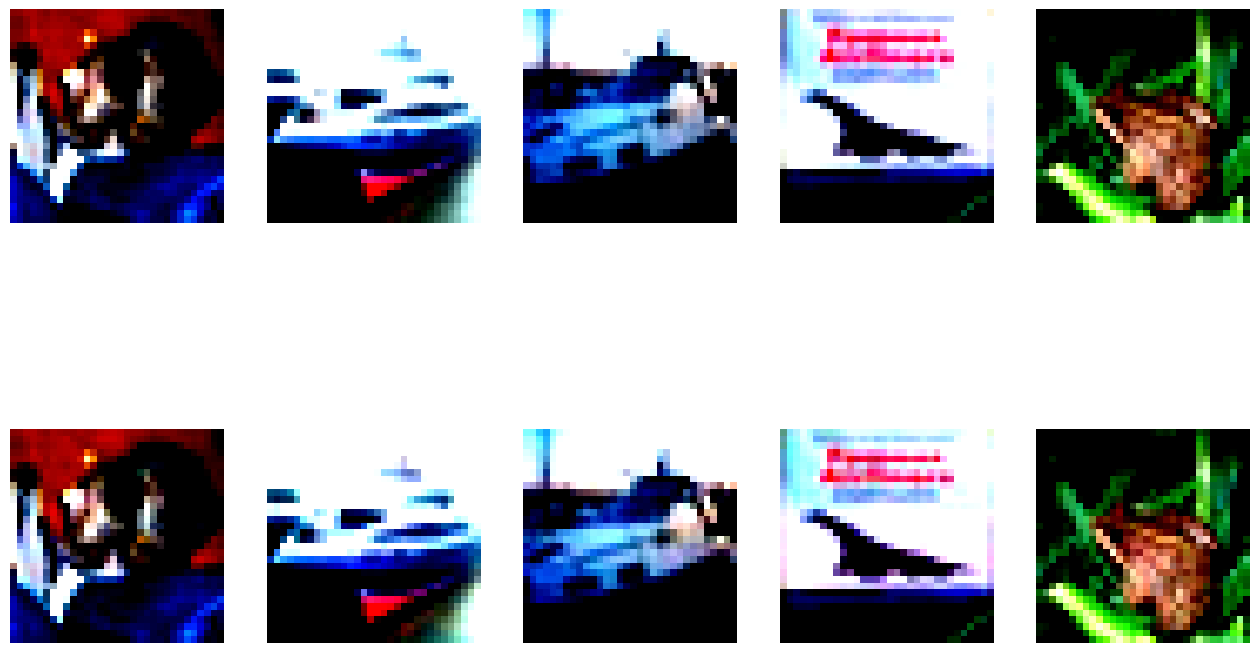

Attack: phase_strong
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 32.03%


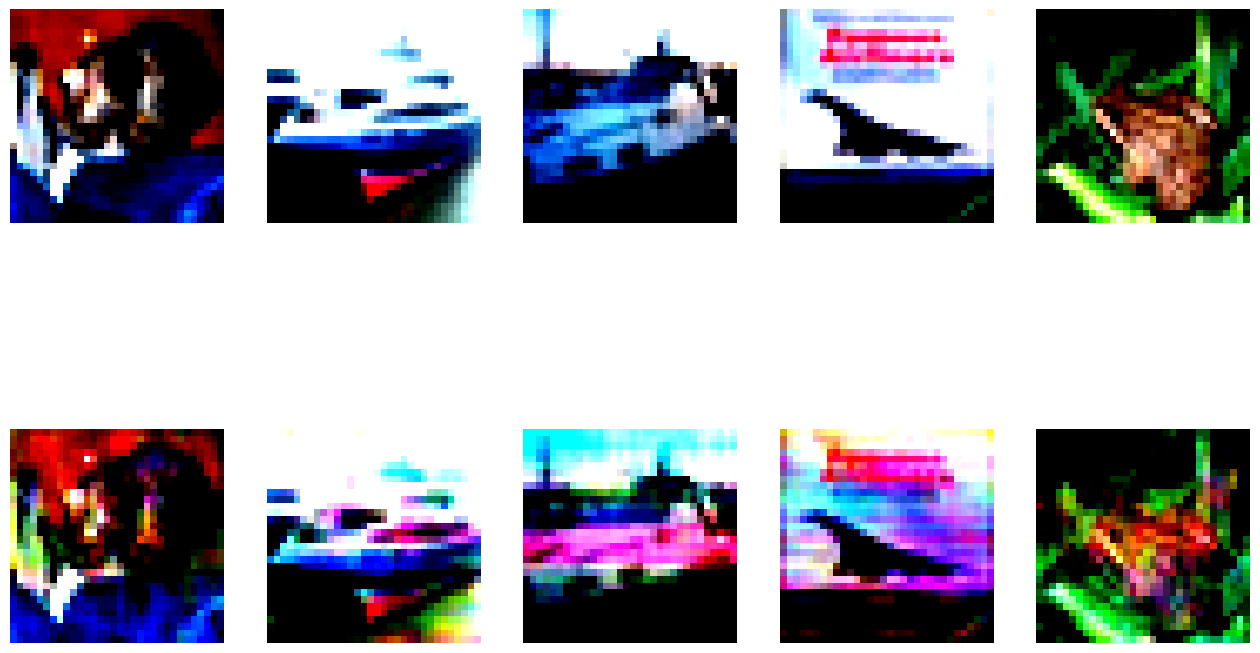

Attack: magnitude_weak
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.22%


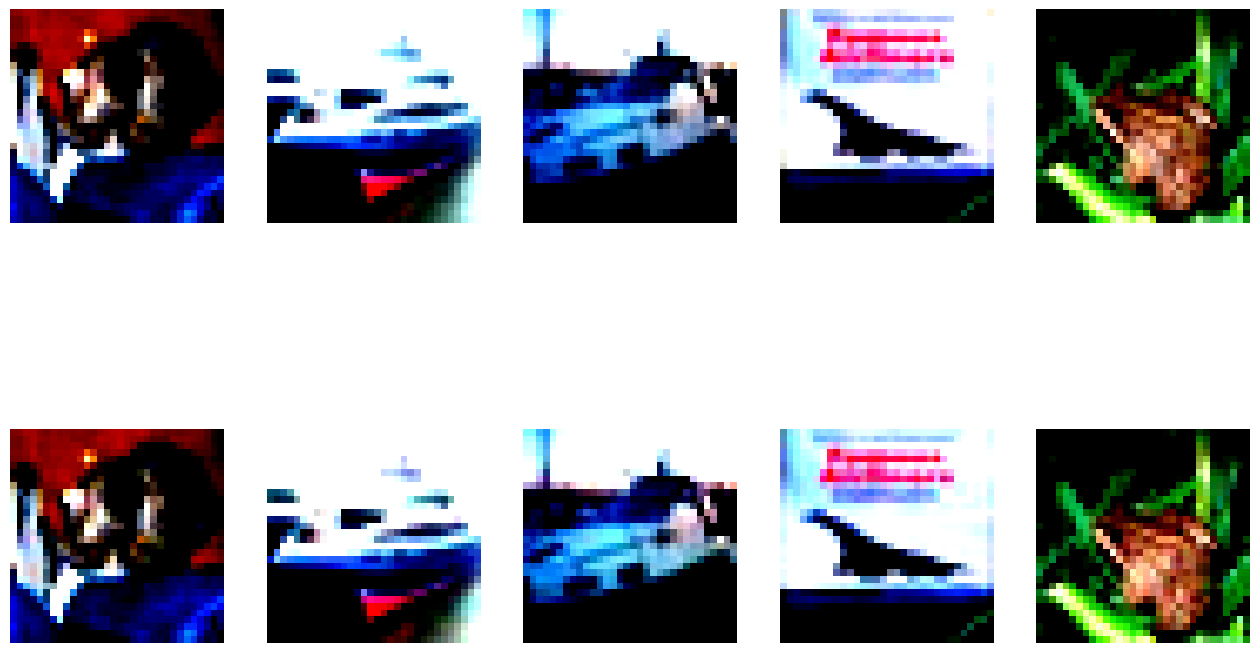

Attack: magnitude_strong
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 32.32%


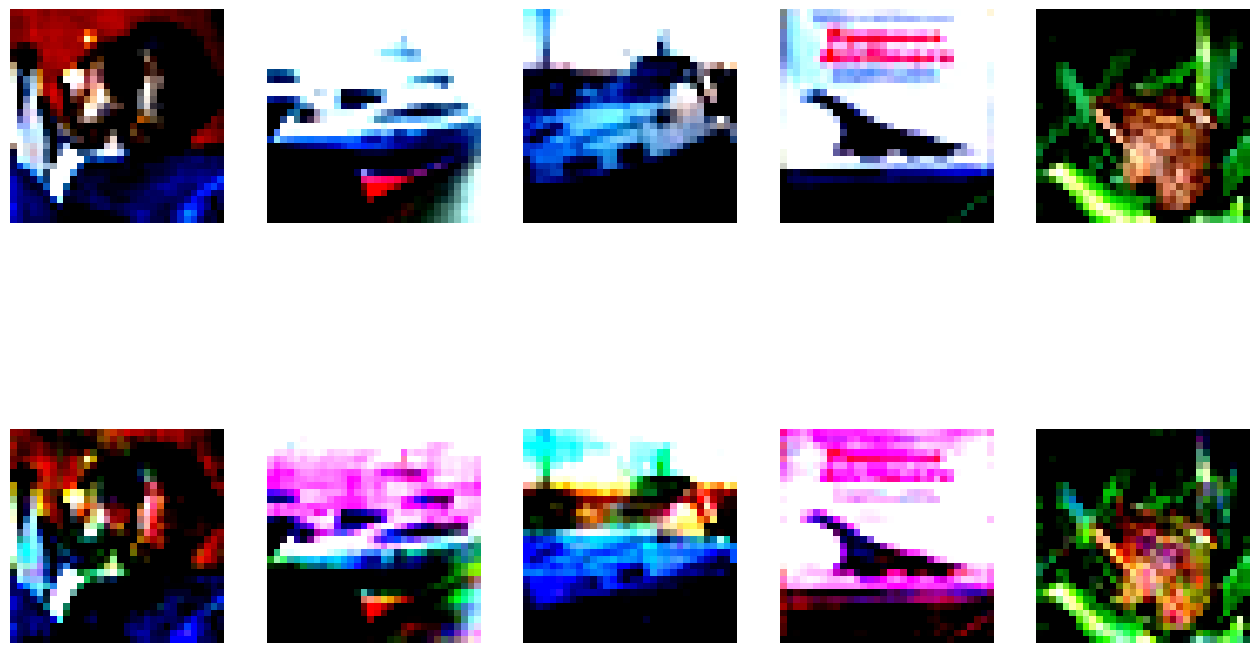

Attack: low_freq_small_radius
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.31%


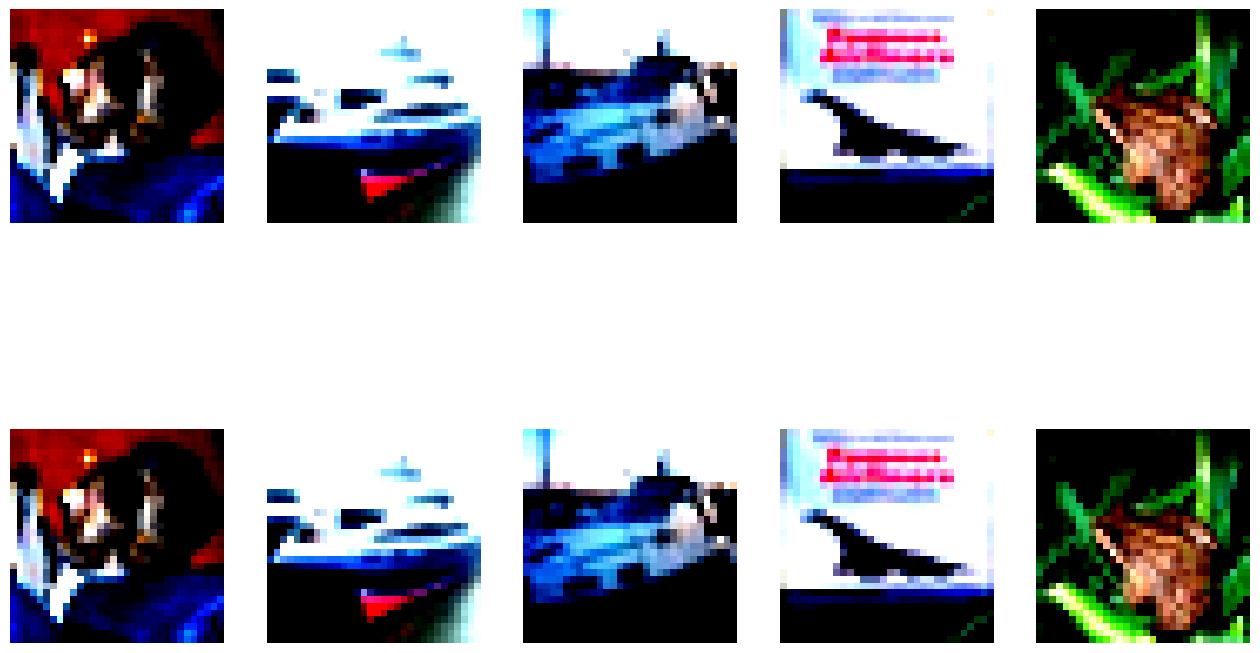

Attack: low_freq_large_radius
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.35%


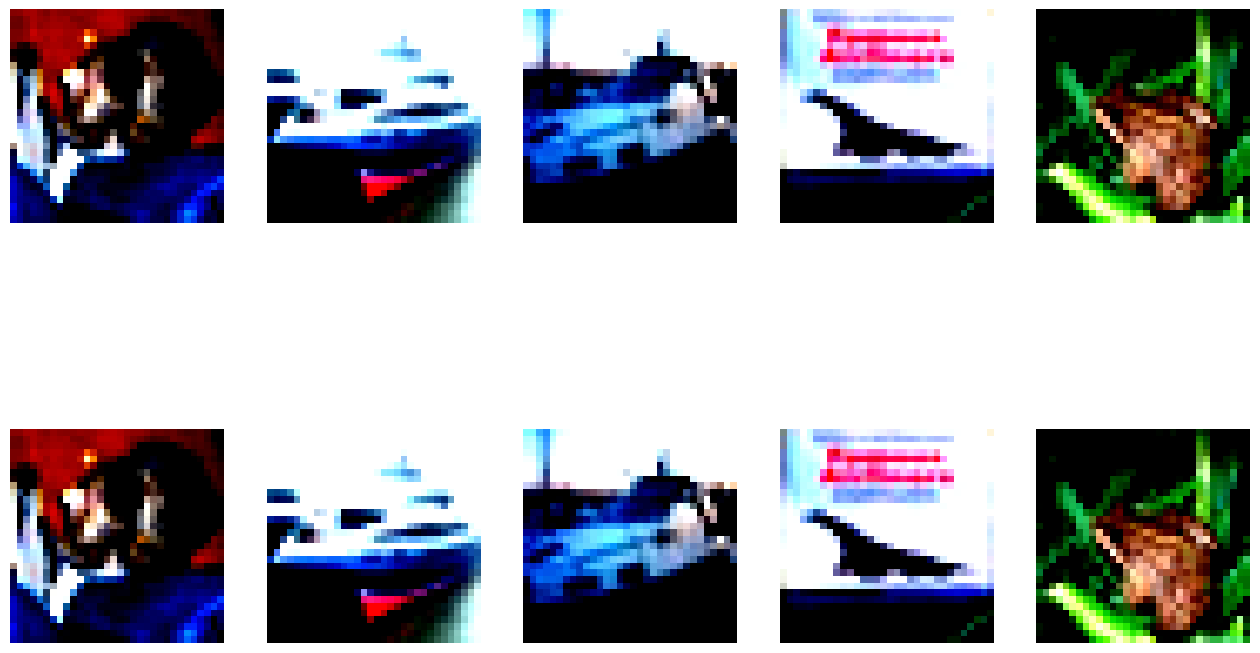

Attack: high_freq_small_radius
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.37%


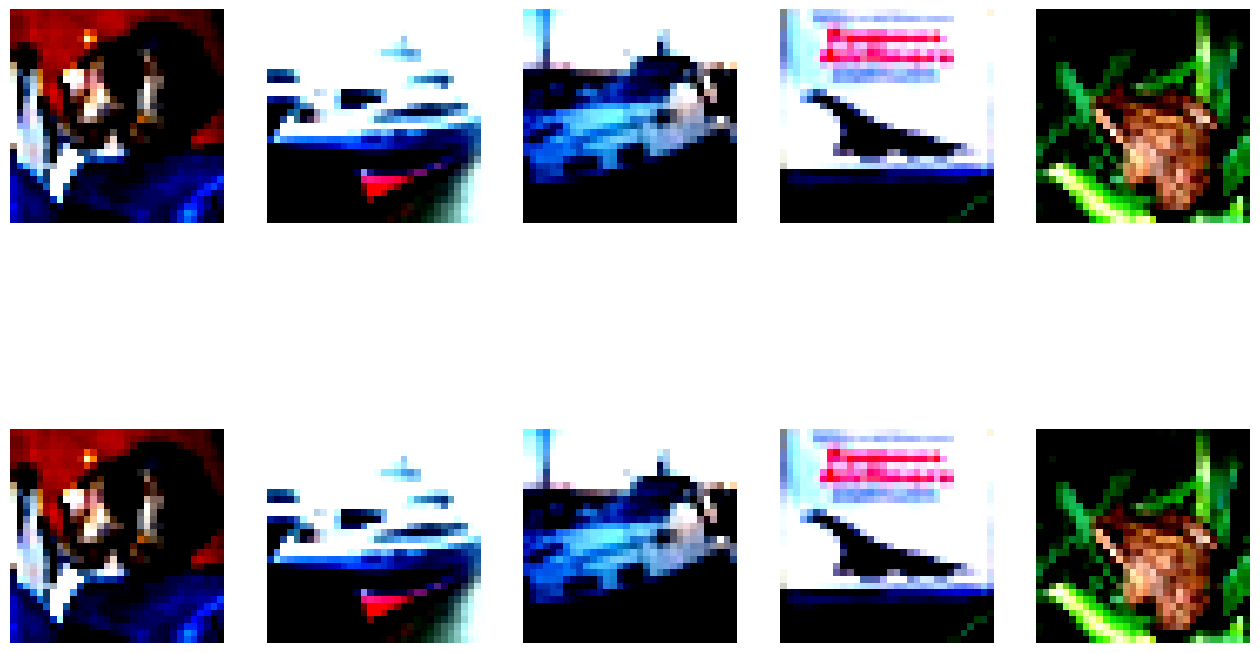

Attack: high_freq_large_radius
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.37%


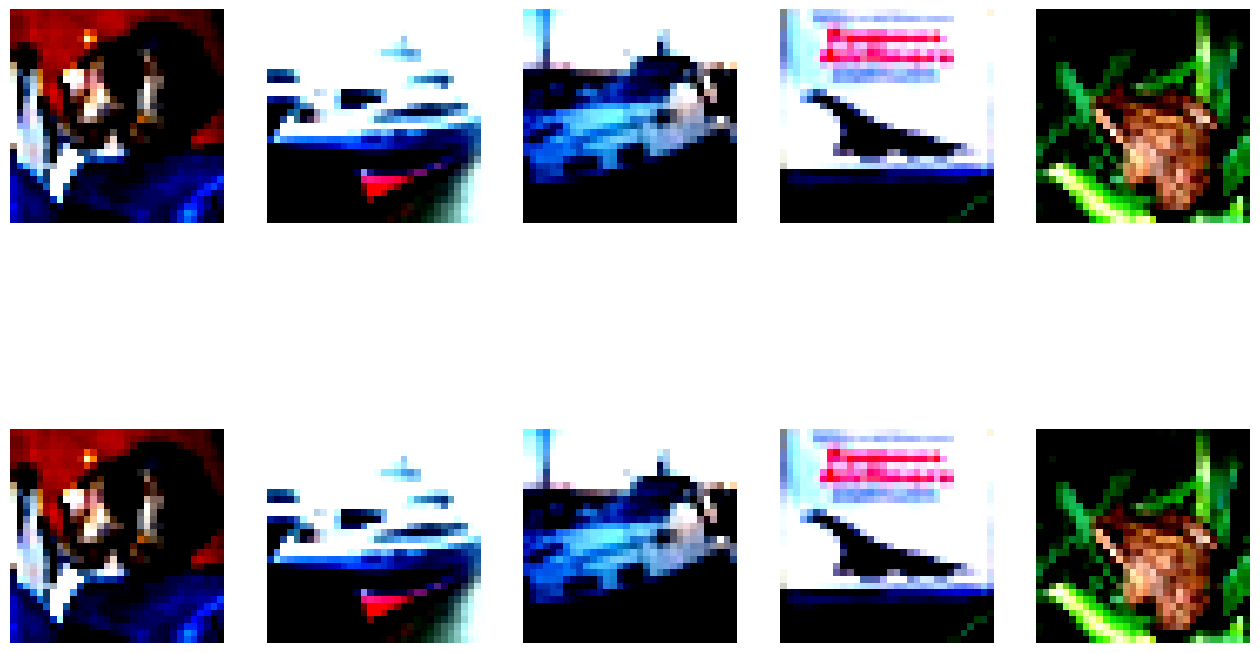

Attack: pixel_few
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.71%


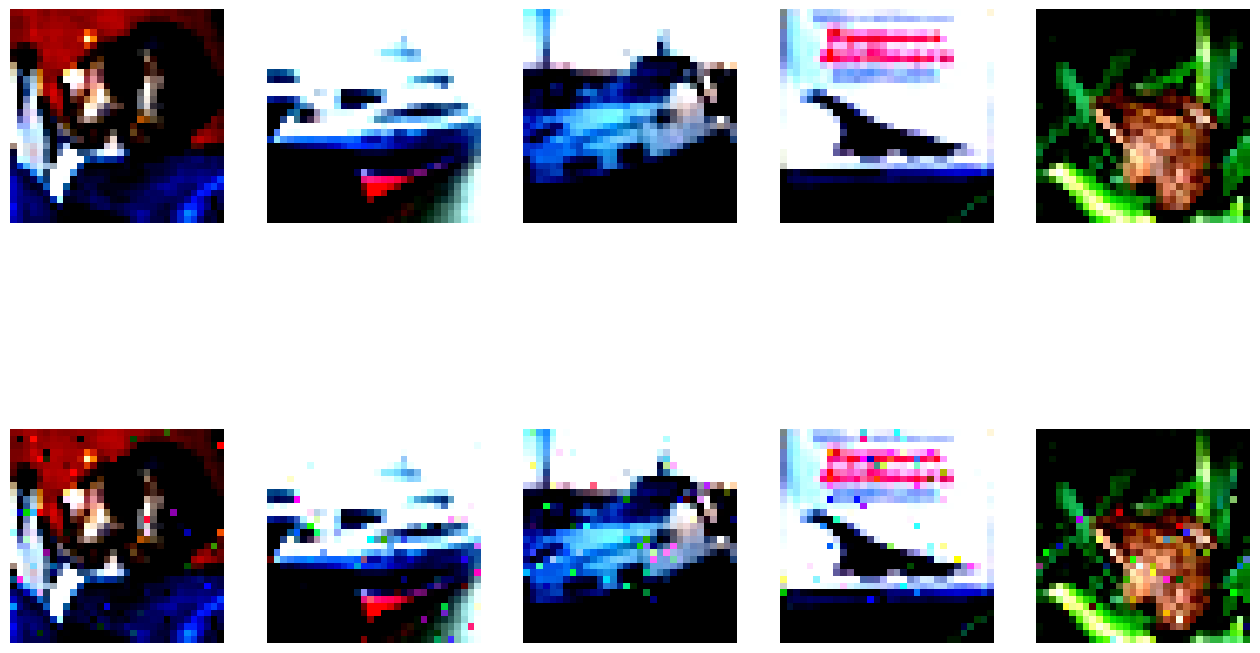

Attack: pixel_many
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 31.61%


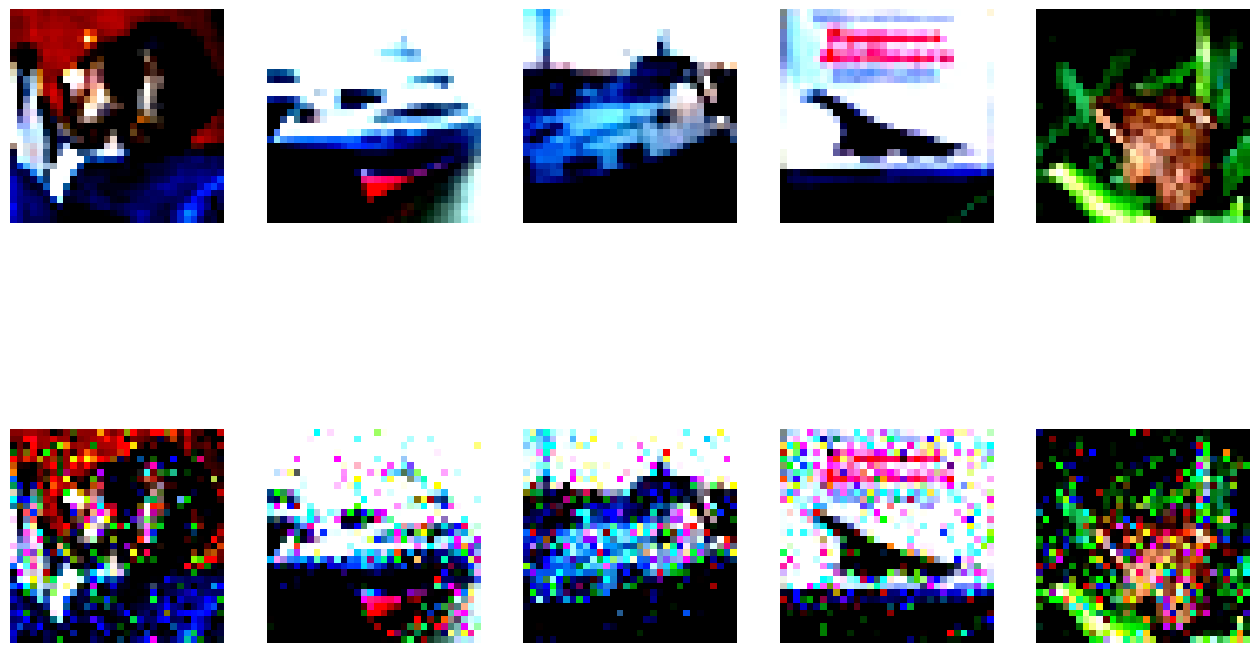

Attack: normal_weak
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 38.50%


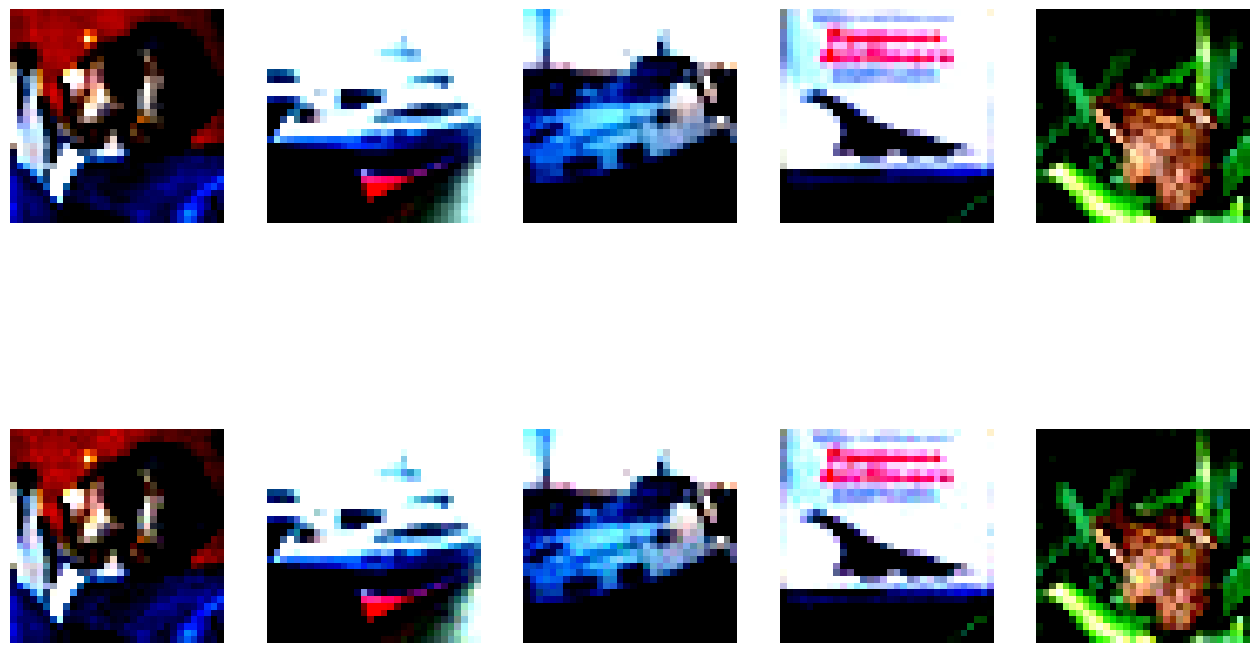

Attack: normal_strong
Total Samples:  10000
Accuracy on Original Images: 74.79%
Accuracy on Perturbed Images: 37.93%


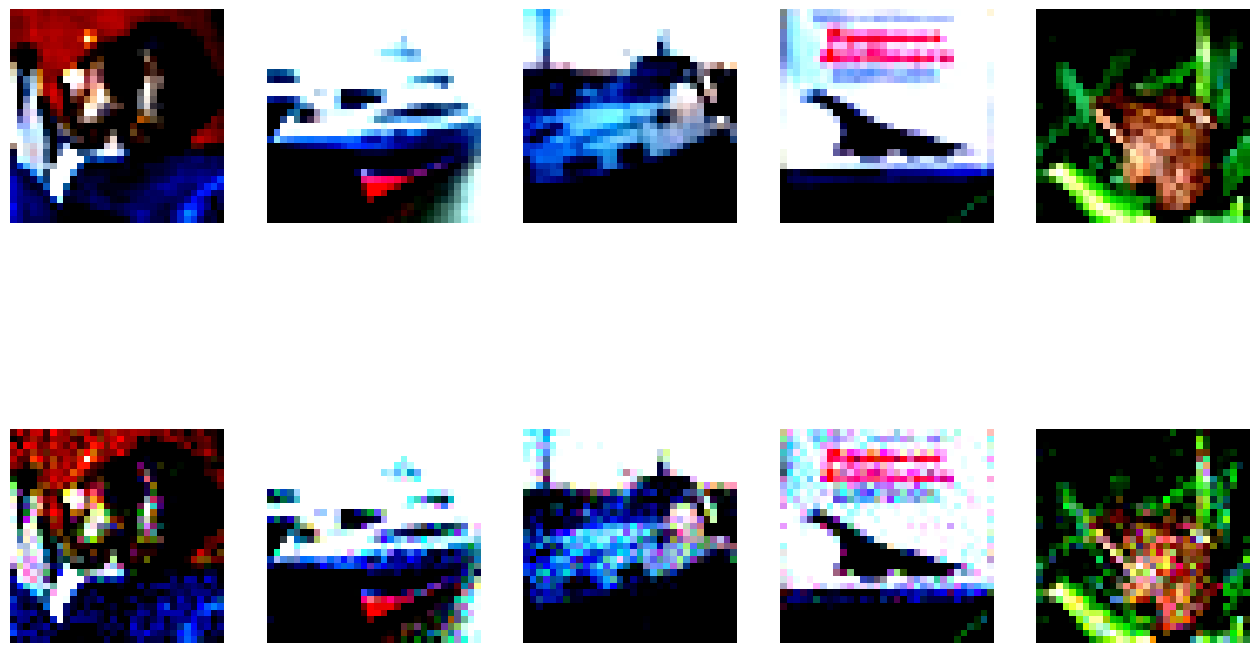

In [22]:
train_adversary(model)

In [9]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_seq_len=2048):
        super().__init__()
        self.d_model = d_model
        
        # Create positional encoding
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Apply sin and cos functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer (not a parameter)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # x: [batch, seq_len, dim]
        seq_len = x.size(1)
        return self.pe[:, :seq_len]

In [24]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, pos_encoding='rope'):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.pos_encoding = pos_encoding
        
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"
        
        # Linear projections
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        
        # Initialize positional encoding based on type
        if pos_encoding == 'rope':
            self.rope = RotaryPositionalEmbedding(self.head_dim)
        elif pos_encoding == 'sincos':
            self.pos_emb = SinusoidalPositionalEmbedding(d_model)
        
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Apply positional embeddings based on type
        if self.pos_encoding == 'sincos':
            # Add positional embeddings to input
            pos_emb = self.pos_emb(x)
            x = x + pos_emb
        
        # Project and reshape for multi-head attention
        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim)
        
        # Apply rotary embeddings if using RoPE
        if self.pos_encoding == 'rope':
            cos, sin = self.rope(x)
            q, k = apply_rotary_pos_emb(q, k, cos, sin)
        
        # Reshape for matrix multiplication
        q = q.transpose(1, 2)  # [batch, heads, seq_len, head_dim]
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # Apply softmax and compute attention output
        attn_weights = F.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)
        
        # Reshape and project output
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.out_proj(attn_output)
        
        return output

In [25]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, pos_encoding='rope'):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, pos_encoding)
        
        # Feed-forward network
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        
        # Layer normalization and dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attn(self.norm1(x), mask)
        x = x + self.dropout(attn_output)
        
        # Feed-forward with residual connection
        ff_output = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_output)
        
        return x

In [26]:
class ViT(nn.Module):
    def __init__(self, 
                 img_size=224, 
                 patch_size=16, 
                 in_channels=3,
                 num_classes=37,
                 dim=768, 
                 depth=12, 
                 heads=12, 
                 mlp_dim=3072, 
                 dropout=0.1,
                 pos_encoding='rope'):
        super().__init__()
        
        # Image and patch dimensions
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.pos_encoding = pos_encoding
        
        # Patch embedding
        self.patch_embedding = nn.Conv2d(in_channels, dim, kernel_size=patch_size, stride=patch_size)
        
        # Class token
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model=dim, num_heads=heads, d_ff=mlp_dim, 
                                   dropout=dropout, pos_encoding=pos_encoding)
            for _ in range(depth)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(dim)
        
        # Classification head
        self.head = nn.Linear(dim, num_classes)
        
    def forward(self, x):
        # x: [batch, channels, height, width]
        batch_size = x.shape[0]
        
        # Create patch embeddings
        x = self.patch_embedding(x)  # [batch, dim, grid, grid]
        x = x.flatten(2).transpose(1, 2)  # [batch, num_patches, dim]
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # [batch, num_patches + 1, dim]
        
        # Apply dropout
        x = self.dropout(x)
        
        # Apply transformer layers
        for layer in self.layers:
            x = layer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0]
        
        # MLP head
        x = self.head(x)
        
        return x

In [27]:
def main():
    # Get user input for the dataset
    dataset_options = ['pets', 'cifar10', 'cifar100']
    dataset_name = input(f"Choose a dataset {dataset_options}: ").lower().strip()
    
    while dataset_name not in dataset_options:
        print(f"Invalid selection. Please choose from {dataset_options}")
        dataset_name = input(f"Choose a dataset {dataset_options}: ").lower().strip()
    
    # Set appropriate image and batch sizes based on dataset
    if dataset_name in ['cifar10', 'cifar100']:
        default_img_size = 32  # CIFAR's native size
        batch_size = 64        # We can use larger batches for smaller images
    else:
        default_img_size = 224  # Original size used for Pets dataset
        batch_size = 32
    
    # Ask for image size
    try:
        img_size = int(input(f"Enter image size (default: {default_img_size}): ") or default_img_size)
    except ValueError:
        img_size = default_img_size
        print(f"Using default image size: {img_size}")
    
    # Ask for positional embedding type
    pos_encoding_options = ['rope', 'sincos']
    pos_encoding = input(f"Choose positional encoding {pos_encoding_options} (default: rope): ").lower().strip()
    
    if pos_encoding not in pos_encoding_options:
        pos_encoding = 'rope'
        print(f"Using default positional encoding: {pos_encoding}")
    
    # Load the dataset
    patch_size = 16 if img_size >= 224 else 4  # Adjust patch size for smaller images
    train_loader, val_loader, class_names = load_dataset(
        dataset_name=dataset_name, 
        batch_size=batch_size, 
        img_size=img_size
    )
    
    num_classes = len(class_names)
    
    print(f"Using image size: {img_size}x{img_size}, patch size: {patch_size}")
    print(f"Using positional encoding: {pos_encoding}")
    
    # Initialize the ViT model
    model = ViT(
        img_size=img_size,
        patch_size=patch_size,
        in_channels=3,
        num_classes=num_classes,
        dim=512,  # Embedding dimension
        depth=8,  # Number of transformer layers
        heads=8,  # Number of attention heads
        mlp_dim=1024,  # Hidden dimension of the MLP
        dropout=0.1,
        pos_encoding=pos_encoding
    )
    model = model.to(device)
    
    # Print model summary
    print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Ask for number of epochs
    try:
        num_epochs = int(input("Enter number of epochs (default: 20): ") or 20)
    except ValueError:
        num_epochs = 20
        print(f"Using default number of epochs: {num_epochs}")
    
    # Train the model
    model, history = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Visualize predictions
    visualize_predictions(model, val_loader, class_names, num_images=16, device=device)
    
    model_filename = f'vit_{dataset_name}_{pos_encoding}.pth'
    torch.save(model.state_dict(), model_filename)
    print(f"Training complete! Model saved as {model_filename}")
    return model

Choose a dataset ['pets', 'cifar10', 'cifar100']:  cifar10
Enter image size (default: 32):  
Choose positional encoding ['rope', 'sincos'] (default: rope):  sincos


Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Number of classes: 10
Training samples: 50000
Validation samples: 10000
Using image size: 32x32, patch size: 4
Using positional encoding: sincos
Model Parameters: 16,854,026


Enter number of epochs (default: 20):  10


Epoch 1/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.5540 Acc: 0.4330


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 1.3078 Acc: 0.5314
New best model saved with accuracy: 0.5314

Epoch 2/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.1991 Acc: 0.5692


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 1.1297 Acc: 0.5967
New best model saved with accuracy: 0.5967

Epoch 3/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 1.0667 Acc: 0.6166


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.9888 Acc: 0.6483
New best model saved with accuracy: 0.6483

Epoch 4/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.9834 Acc: 0.6509


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.9635 Acc: 0.6566
New best model saved with accuracy: 0.6566

Epoch 5/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.9162 Acc: 0.6744


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.8861 Acc: 0.6830
New best model saved with accuracy: 0.6830

Epoch 6/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8587 Acc: 0.6941


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.8990 Acc: 0.6861
New best model saved with accuracy: 0.6861

Epoch 7/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.8150 Acc: 0.7099


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.8293 Acc: 0.7094
New best model saved with accuracy: 0.7094

Epoch 8/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7763 Acc: 0.7250


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.8351 Acc: 0.7136
New best model saved with accuracy: 0.7136

Epoch 9/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.7292 Acc: 0.7424


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7684 Acc: 0.7269
New best model saved with accuracy: 0.7269

Epoch 10/10
----------


Training:   0%|          | 0/782 [00:00<?, ?it/s]

Train Loss: 0.6954 Acc: 0.7520


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Val Loss: 0.7682 Acc: 0.7347
New best model saved with accuracy: 0.7347



<ipython-input-12-8911ceb2fbec>:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_model.pth'))


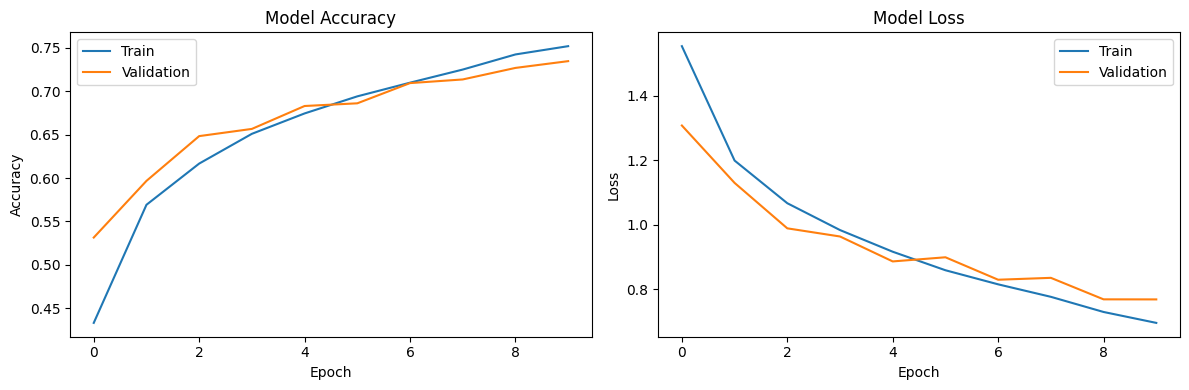

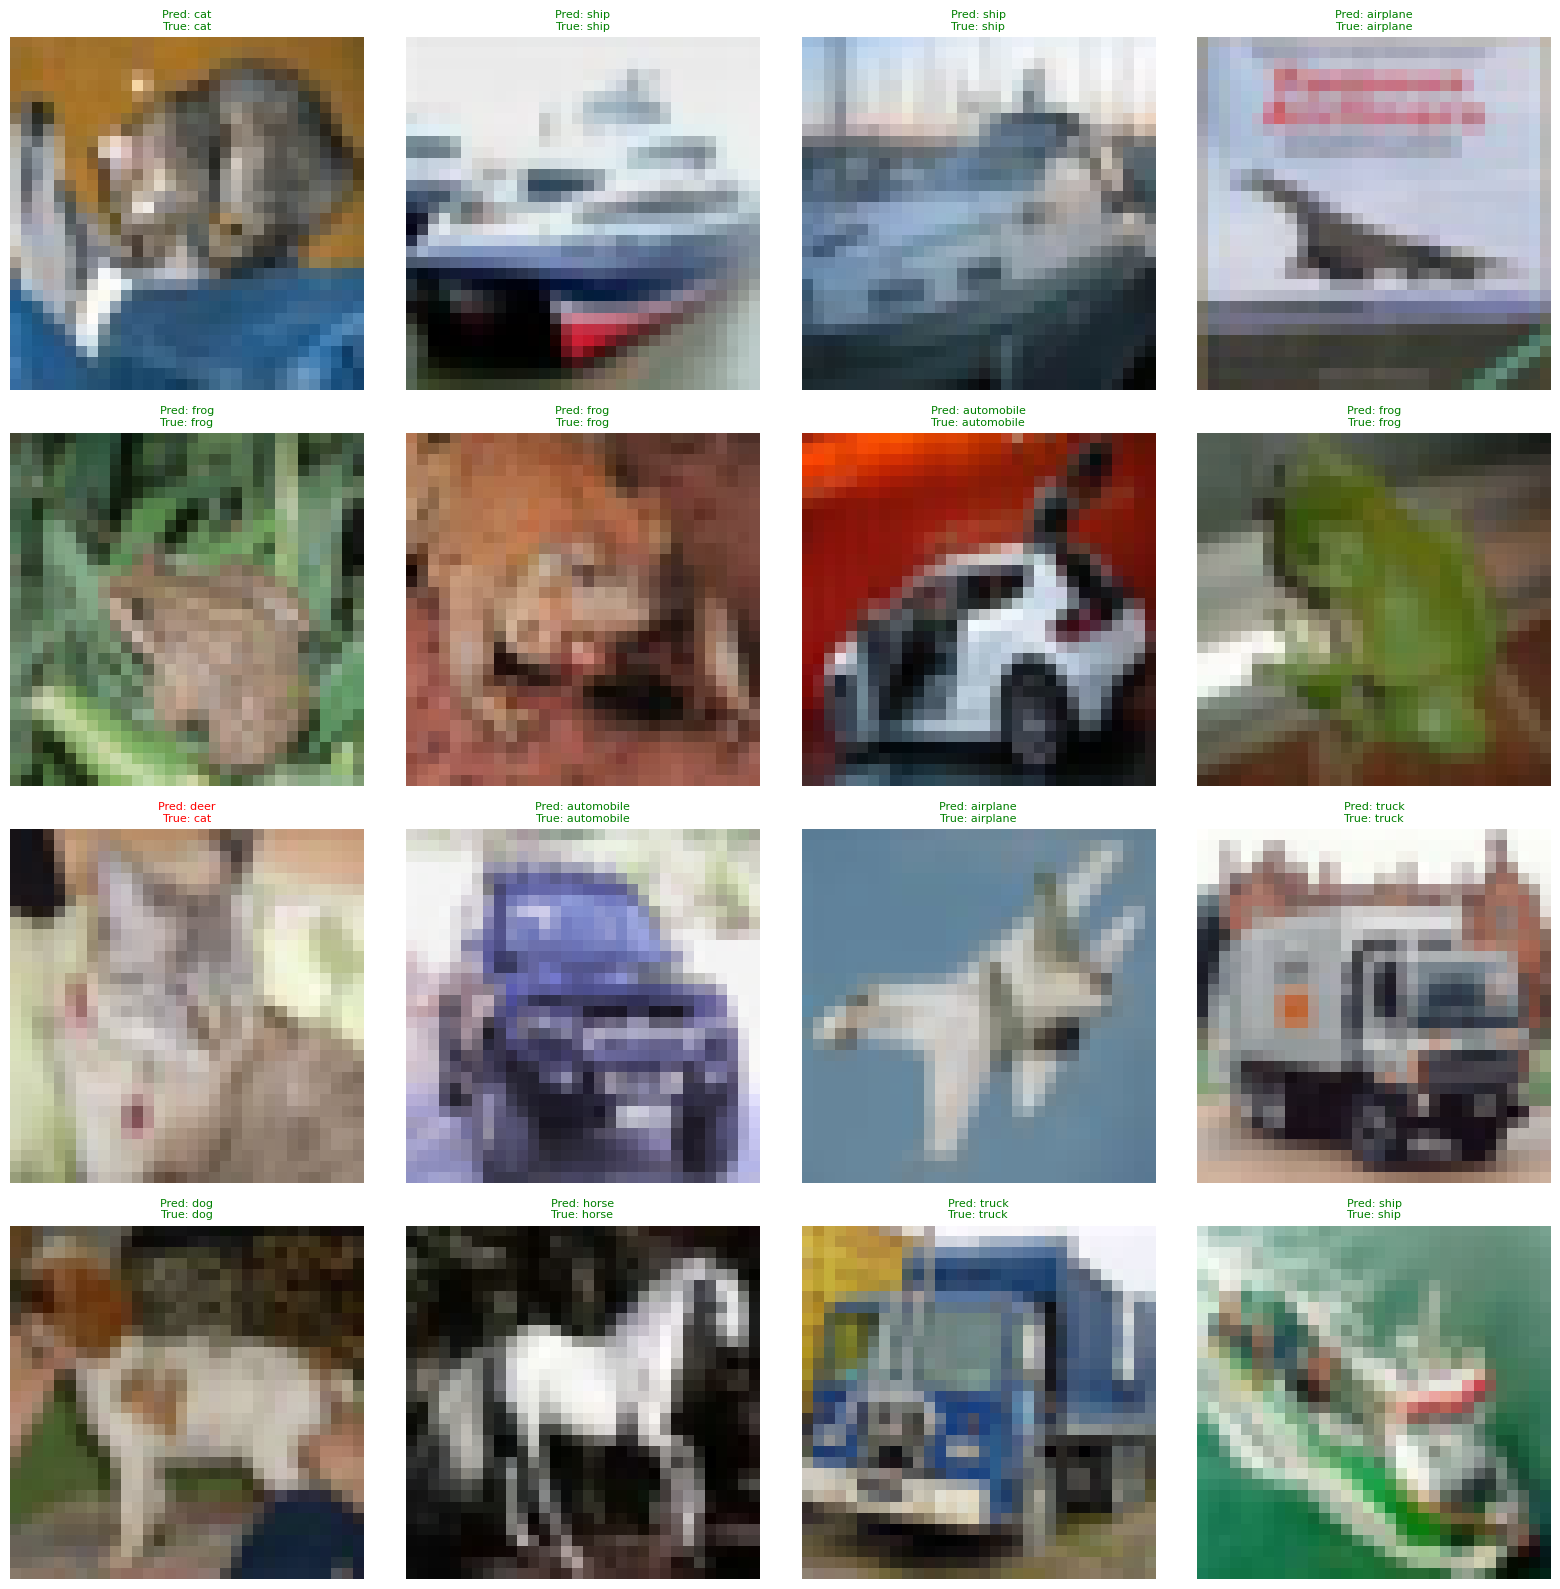

Training complete! Model saved as vit_cifar10_sincos.pth


In [28]:
model = main()

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Number of classes: 10
Training samples: 50000
Validation samples: 10000
Attack: phase_weak
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.25%


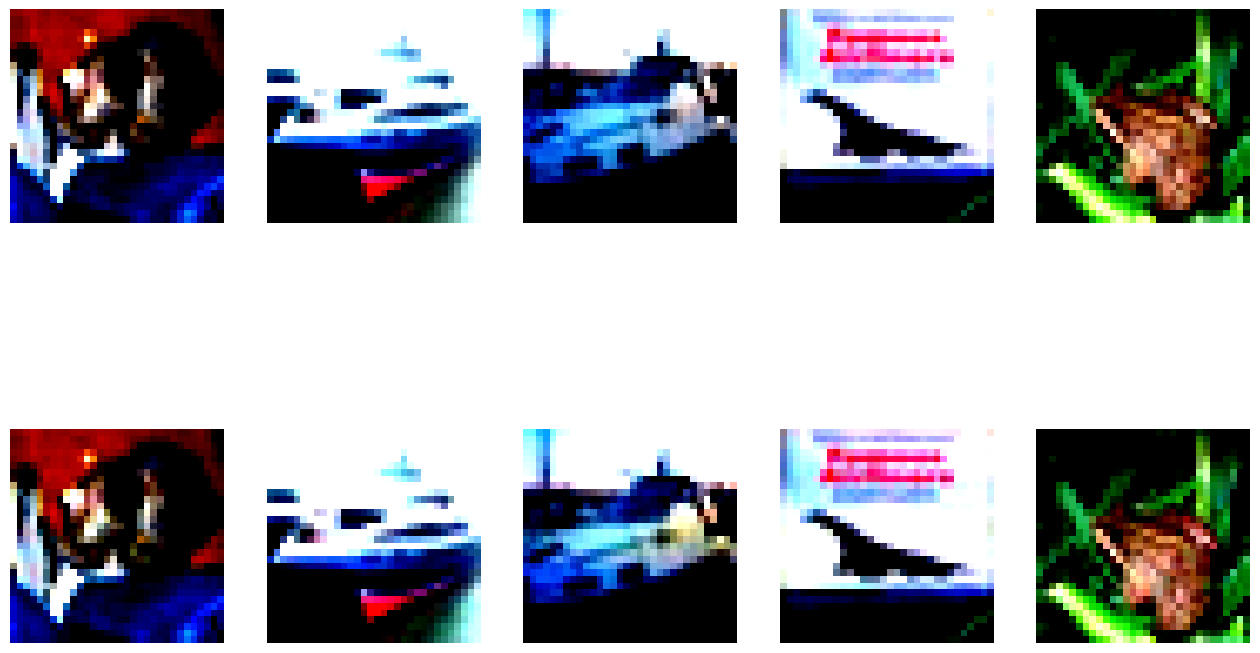

Attack: phase_strong
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 33.76%


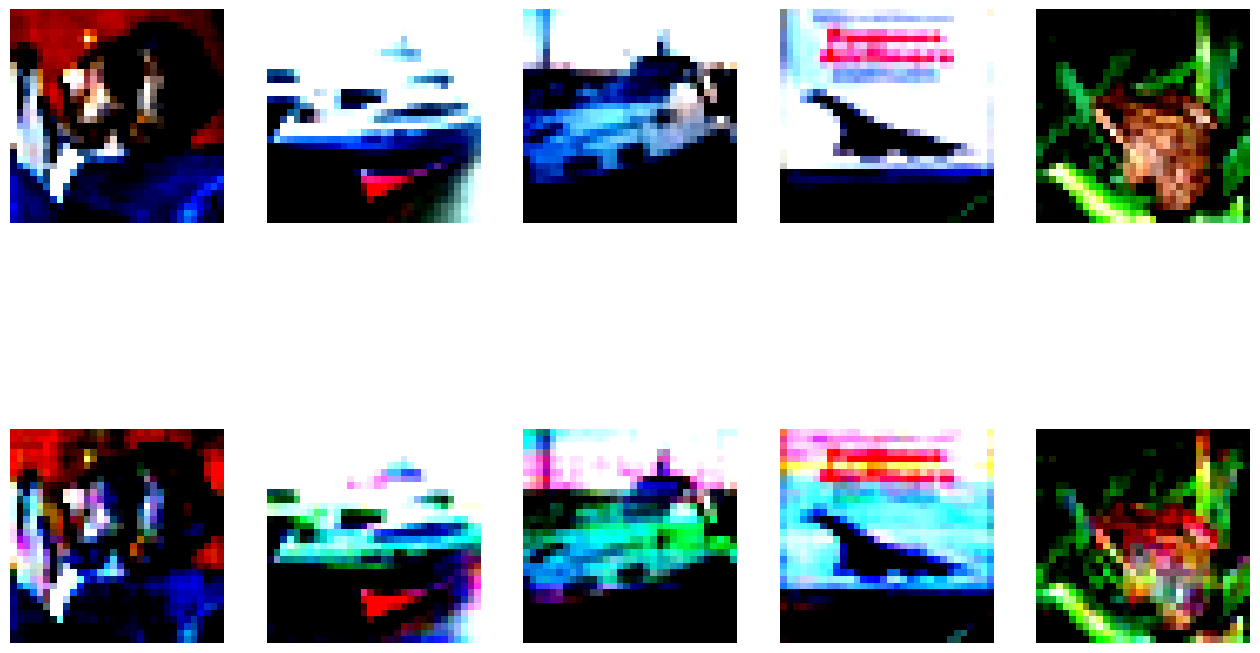

Attack: magnitude_weak
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 41.78%


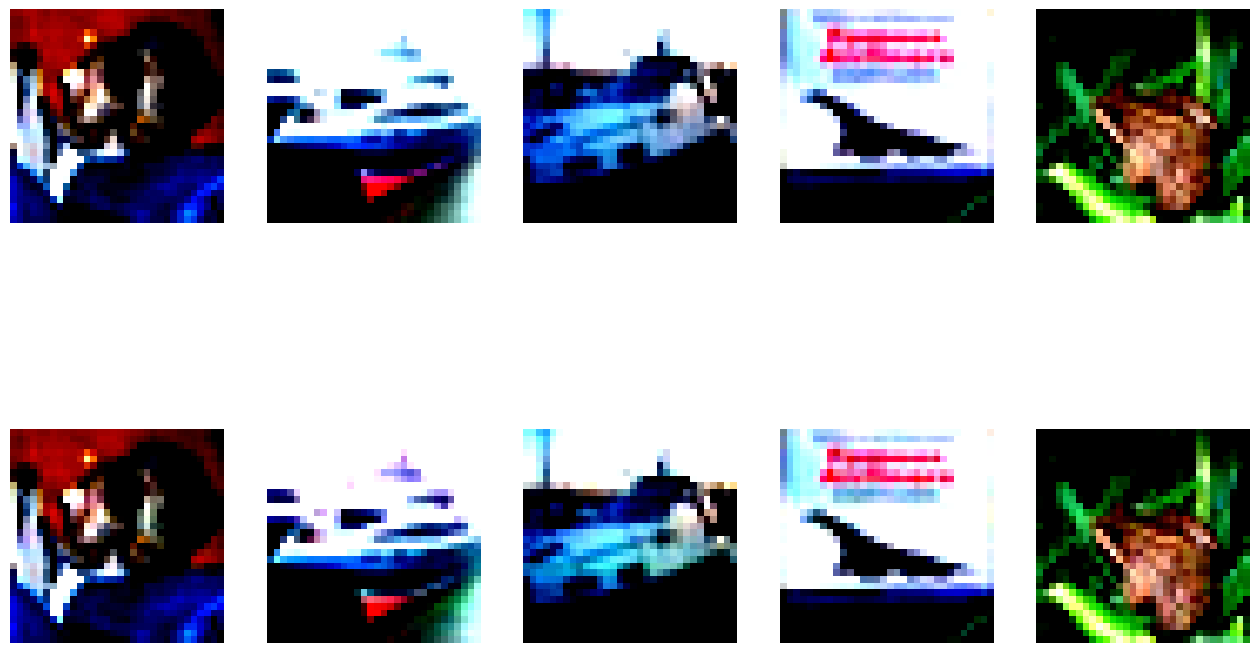

Attack: magnitude_strong
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 33.36%


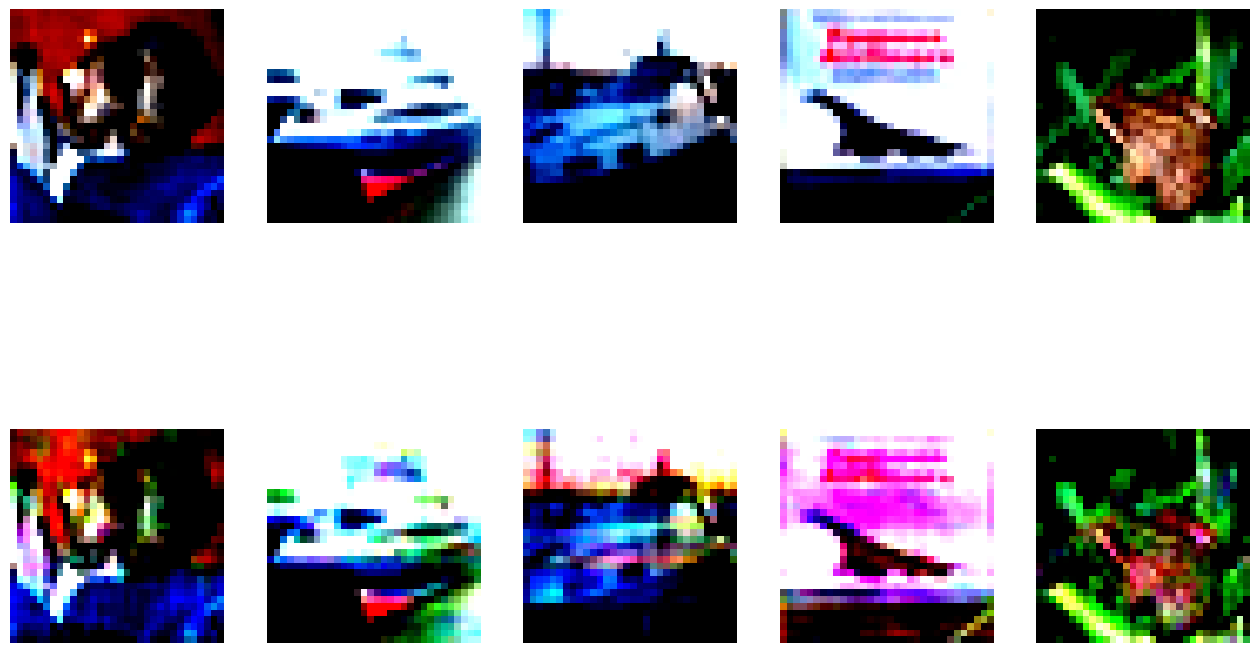

Attack: low_freq_small_radius
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.80%


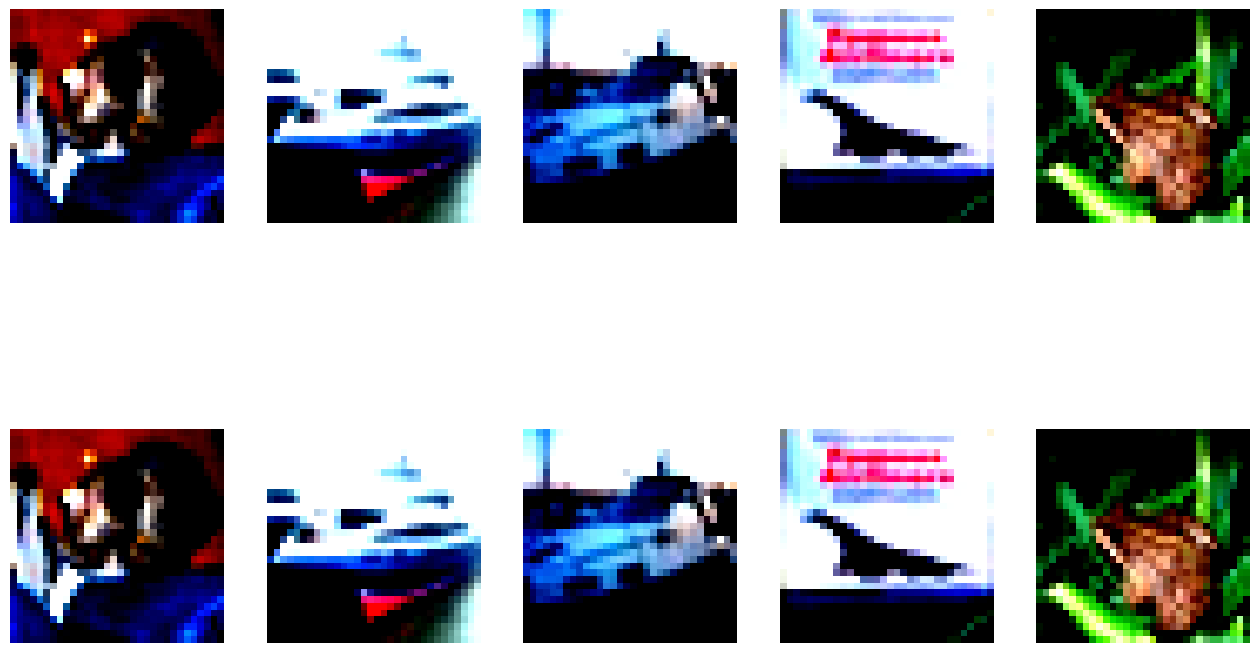

Attack: low_freq_large_radius
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.73%


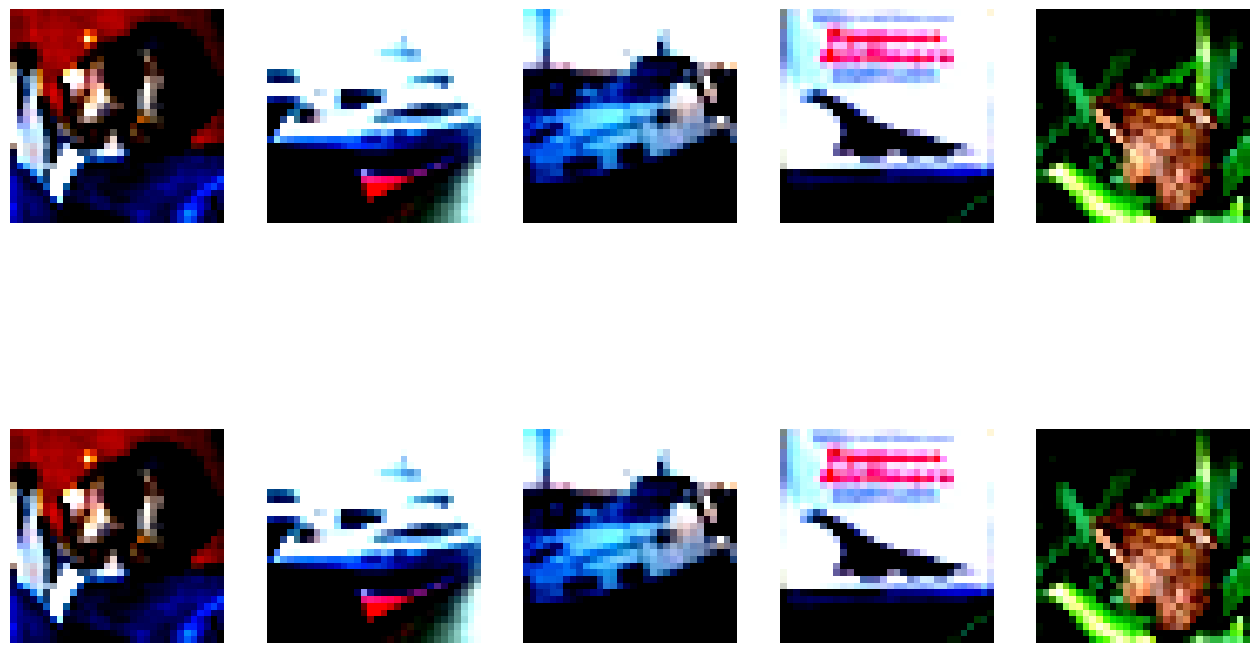

Attack: high_freq_small_radius
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.79%


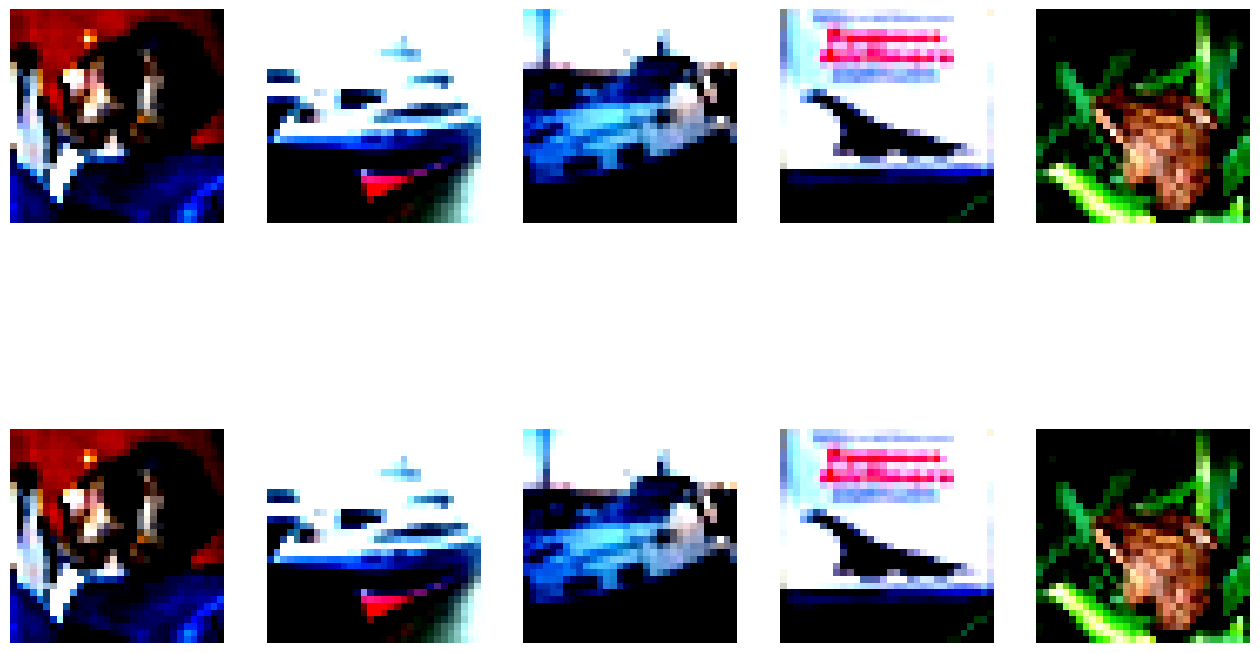

Attack: high_freq_large_radius
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.79%


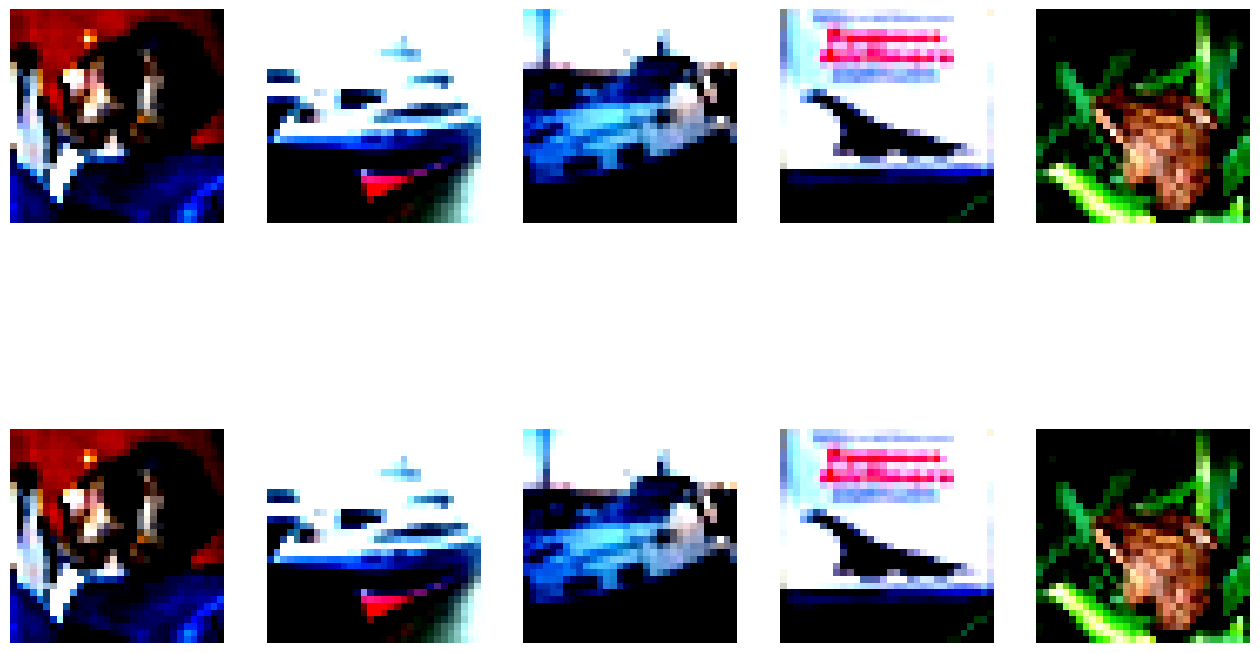

Attack: pixel_few
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 41.99%


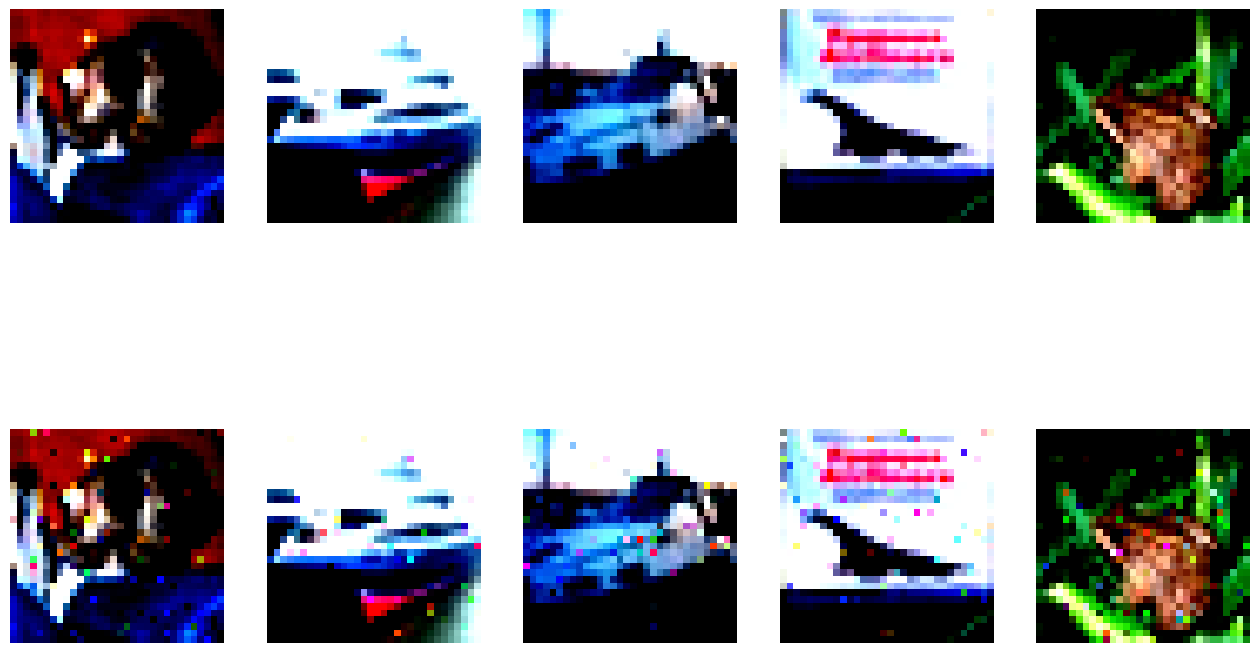

Attack: pixel_many
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 35.91%


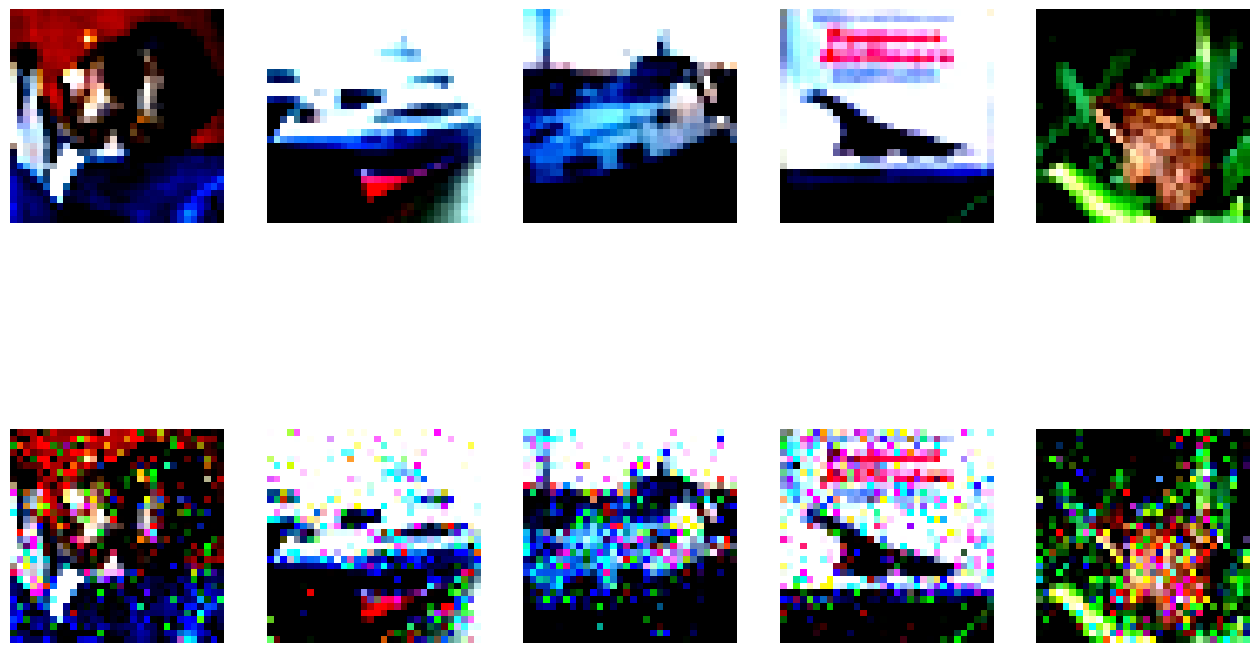

Attack: normal_weak
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 42.47%


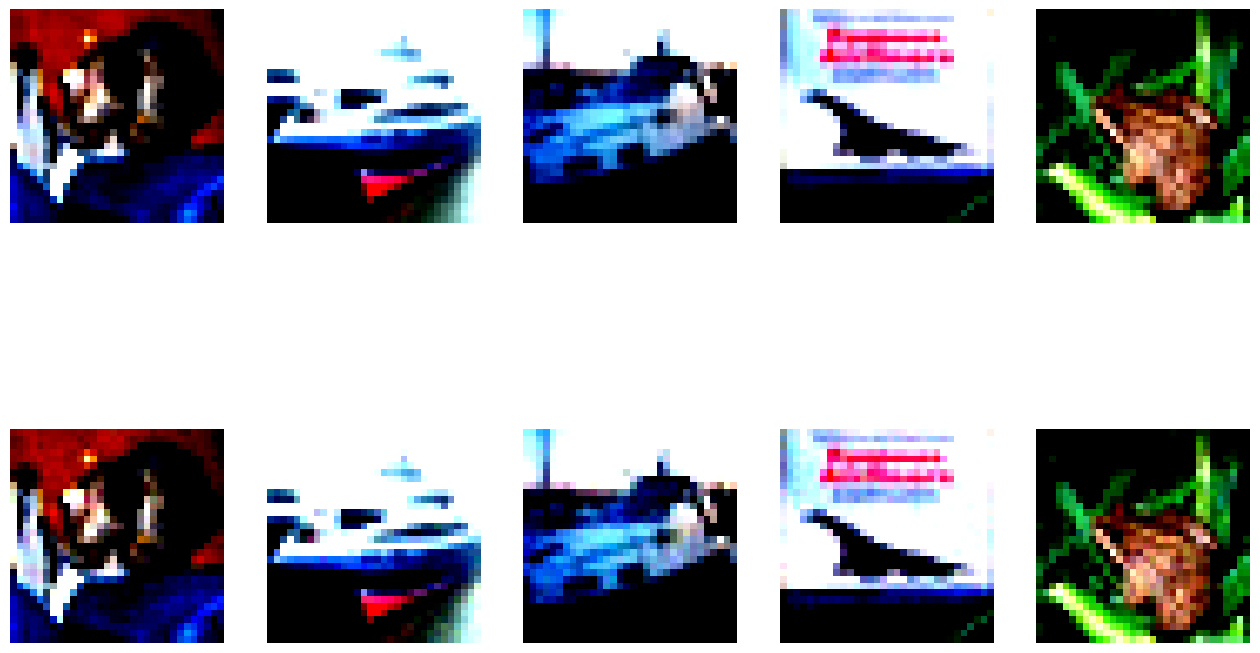

Attack: normal_strong
Total Samples:  10000
Accuracy on Original Images: 73.47%
Accuracy on Perturbed Images: 41.22%


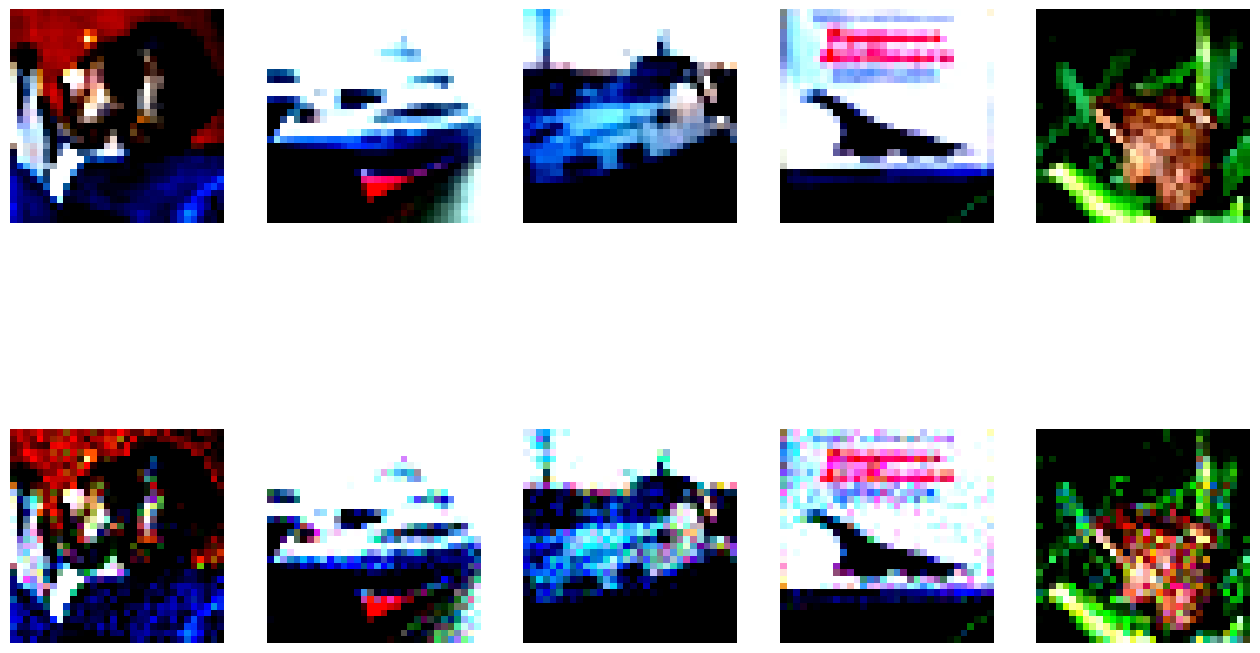

In [31]:
train_adversary(model)